# Introduction:

Welcome to Samar Haider, Kaishu Mason, and Kyle Sullivan's CIS 545 Final Project for Spring 2022!

In this notebook, we will dive into the world of NCAA men's basketball. Every year, March Madness draws national attention as schools from across the country compete in a large multi-week tournament to crown college basketball's next champion. Perhaps the most significant athletic competition for data enthusiasts, these numerous high-stake elimination games between typically unfamiliar opponents present an excellent opportunity to build and test predictive sports models.

Our goal is to analyze college basketball data from 2003 to 2022 to produce a model that predicts matchup winners and losers, with the ultimate goal of accurately predicting the 2022 March Madness tournament.

# Install/Import the revelant libraries and packages.
We will be using Pandas, Pandas SQL, Geopandas, Geopy, and Plotly.

In [ ]:
!pip install pandas==1.1.5
!pip install pandasql
!pip install geopandas
!pip install geopy
!pip install plotly

     |████████████████████████████████| 9.5 MB 4.9 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=3eac278606f8f336a628198f6dd5247d1bb9a8bc88071dc517836e2a16efa911
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql
     |████████████████████████████████| 1.0 MB 5.6 MB/s 
     |████████████████████████████████| 16.7 MB 8.0 MB/s 
     |████████████████████████████████| 6.3 MB 36.3 MB/s 


In [ ]:
import pandas as pd
import pandasql as ps

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import geopandas
import geopy
from geopy.extra.rate_limiter import RateLimiter

# Import the Data

Connect to the google drive and download the necessary csv files.

In [ ]:
# Setup google drive:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


We will be using the following datasets from Kaggle:


*   MRegularSeasonDetailedResults.csv
*   MConferenceTourneyGames.csv
*   MNCAATourneyDetailedResults.csv
*   MNCAATourneySeeds.csv
*   MTeamCoaches.csv
*   MTeams.csv
*   MTeamConferences.csv
*   Conferences.csv
*   MMasseyOrdinals_thruDay128.csv
*   MGameCities.csv
*   Cities.csv





In [ ]:
# Read the data from Google Drive:
reg_season_detailed_df = pd.read_csv('/content/MRegularSeasonDetailedResults.csv')
conf_tourney_games_df = pd.read_csv('/content/MConferenceTourneyGames.csv')
tourney_games_detailed_df = pd.read_csv('/content/MNCAATourneyDetailedResults.csv')
tourney_seeds_df = pd.read_csv('/content/MNCAATourneySeeds.csv')
team_coaches_df = pd.read_csv('/content/MTeamCoaches.csv')
teams_df = pd.read_csv('/content/MTeams.csv')
team_conf_df = pd.read_csv('/content/MTeamConferences.csv')
conferences_df = pd.read_csv('/content/Conferences.csv')
massey_ordinals_df = pd.read_csv('/content/MMasseyOrdinals_thruDay128.csv')
game_cities_df = pd.read_csv('/content/MGameCities.csv')
cities_df = pd.read_csv('/content/Cities.csv')

# Wrangling

## Combine the regular season and March Madness tournament game DataFrames

First, we want to gather our game data into a single DataFrame (combined_detailed_df). We'll accomplish this task by concatenating the March Madness tournament games (tourney_games_detailed_df) to the regular season games (reg_season_detailed_df). At the same time, let's insert 'ConfTourney' and 'MMTourney' columns into the result taking binary values of 0 or 1 to indicate if this game instance was a conference tournament game or a March Madness tournament game. Note that the regular season DataFrame (reg_season_detailed_df) already includes conference tournament games.

In [ ]:
# Add an MMTourney column to reg_season_detailed_df that takes 1 or 0.
# Since reg_season_detailed_df doesn't contain any MMTourney games, all entries are set to 0.
reg_season_detailed_df['MMTourney'] = 0

# Add a 'ConfTourney' column to reg_season_detailed_df taking a 1 if the game was a conference tournament match or 0 if not.
# Note that reg_season_detailed_df already contains all of the conference tournament games.

# We accomplish this by left merging reg_season_detailed_df and conf_tourney_games_df with the indicator column set to True.
# Initially we use a temp_df to hold these changes, but once everything checks out, we'll finish by setting
#    reg_season_detailed_df to temp_df.
temp_df = reg_season_detailed_df.merge(conf_tourney_games_df.drop(columns=['ConfAbbrev']), how='left',
                                       on=['Season', 'DayNum', 'WTeamID', 'LTeamID'], indicator=True)

# Next, we check where the indicator column '_merge' equals 'both' – these are instances found in both
#    reg_season_detailed_df and conf_tourney_games_df. Using the apply method, set the 'ConfTourney' values
#    of these 'both' rows to 1, and all others to 0. Basically, if the game was in our conf_tourney_games_df,
#    its 'ConfTourney' value should be 1, and all other games should have a 0 here.
temp_df['ConfTourney'] = temp_df.apply(lambda row : 1 if row['_merge'] == 'both' else 0, axis=1)

# Remove the '_merge' column now that it is no longer needed.
temp_df = temp_df.drop(columns=['_merge'])

# Finish by setting reg_season_detailed_df equal to temp_df.
reg_season_detailed_df = temp_df

# Now, add 'ConfTourney' and 'MMTourney' columns to tourney_games_detailed_df.
# Since all of the games in tourney_games_detailed_df are exlusively MMTourney games, everything in 'ConfTourney' gets set to 0
#    and everything in 'MMTourney' gets set to 1.
tourney_games_detailed_df['ConfTourney'] = 0
tourney_games_detailed_df['MMTourney'] = 1


# To finish, let's combine (concatenate) all reg_season_detailed_df and tourney_games_detailed_df into combined_detailed_df.
frames = [reg_season_detailed_df, tourney_games_detailed_df]
combined_detailed_df = pd.concat(frames)
combined_detailed_df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,MMTourney,ConfTourney
0,2003,10,1104,68,1328,62,N,0,27,58,...,22,10,22,8,18,9,2,20,0,0
1,2003,10,1272,70,1393,63,N,0,26,62,...,20,20,25,7,12,8,6,16,0,0
2,2003,11,1266,73,1437,61,N,0,24,58,...,23,31,22,9,12,2,5,23,0,0
3,2003,11,1296,56,1457,50,N,0,18,38,...,15,17,20,9,19,4,3,23,0,0
4,2003,11,1400,77,1208,71,N,0,30,61,...,27,21,15,12,10,7,1,14,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,2021,148,1211,85,1425,66,N,0,33,66,...,19,7,20,9,9,7,0,13,1,0
1177,2021,148,1417,51,1276,49,N,0,21,54,...,11,8,24,12,14,5,3,11,1,0
1178,2021,152,1124,78,1222,59,N,0,29,55,...,16,13,12,10,10,4,5,10,1,0
1179,2021,152,1211,93,1417,90,N,1,37,63,...,21,7,24,21,9,4,1,16,1,0


## Convert 'Winners' and 'Losers' to 'Team' and 'Opponent', such that the victors and defeated appear in each, effectively doubling our game instances while removing outcome indicative identifying columns

Now that we have all of our game instances in a single DataFrame, let's remove the winner and loser indicators.

Initially, games have winners (and all of their stats) in separate columns from losers (and all of their stats). However, we don't want this division. Instead, teams should appear in 'TeamID' and 'OppTeamID' columns, with their stats following a similar naming convention. Rather than arbitrarily deciding which team will be labeled the 'opponent', we will create two instances of every matchup, with each team appearing once as the 'team' and once as the 'opponent'. This will allow us to predict win/loss outcomes from the perspective of 'TeamID'. Without making these changes, we would be predicting outcomes from the perspective of either 'WTeamID'  or 'LTeamID' exclusively, which would produce a trivial always 'win' or always 'loss' prediction. Furthermore, this produces class parity, with half of our game labels being wins and the other half being losses.

In [ ]:
# Create winners_combined_games_df from the winners in combined_detailed_df.

# Make a winners_combined_games_df from combined_detailed_df, with the columns reordered.
winners_combined_games_df = combined_detailed_df[['Season', 'DayNum', 'ConfTourney', 'MMTourney', 'WTeamID', 'LTeamID', 'WLoc', 'NumOT', 'WScore', 'LScore',
                                                  'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF',
                                                  'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']]

# Standardize the winners_combined_games_df columns by removing winner and loser naming conventions,
#    changing 'WTeamID' to 'TeamID' and 'LTeamID' to 'OppTeamID'. Do the same for their respective stats.
winners_combined_games_df = winners_combined_games_df.rename(columns={'WTeamID': 'TeamID', 'LTeamID': 'OppTeamID', 'WLoc': 'Loc', 'WScore': 'Score', 'LScore': 'OppScore',

                                                                      'WFGM': 'FGM', 'WFGA': 'FGA', 'WFGM3': 'FGM3', 'WFGA3': 'FGA3', 'WFTM': 'FTM', 'WFTA': 'FTA',
                                                                      'WOR': 'OR', 'WDR': 'DR', 'WAst': 'Ast', 'WTO': 'TO', 'WStl': 'Stl', 'WBlk': 'Blk', 'WPF': 'PF',

                                                                      'LFGM': 'OppFGM', 'LFGA': 'OppFGA', 'LFGM3': 'OppFGM3', 'LFGA3': 'OppFGA3', 'LFTM': 'OppFTM',
                                                                      'LFTA': 'OppFTA', 'LOR': 'OppOR', 'LDR': 'OppDR', 'LAst': 'OppAst', 'LTO': 'OppTO', 'LStl': 'OppStl',
                                                                      'LBlk': 'OppBlk', 'LPF': 'OppPF'
                                                                      })

# Create a 'ScoreDiff' column to hold the difference between TeamID's score and OppTeamID's score.
# These values will all be positive since TeamID currently only holds the winning team IDs.
winners_combined_games_df['ScoreDiff'] = winners_combined_games_df['Score'] - winners_combined_games_df['OppScore']

# Add an 'Outcome' column, which will have 'W' values signifying that TeamID won. Note that this could also be infered from
#    the positive score difference. 'W' and 'L' Outcomes can easily be converted to 1 and 0 later for ML applications.
winners_combined_games_df['Outcome'] = 'W'

In [ ]:
# Create losers_combined_games_df from the losers in combined_detailed_df.

# Make a losers_combined_games_df from combined_detailed_df, with the columns reordered.
losers_combined_games_df = combined_detailed_df[['Season', 'DayNum', 'ConfTourney', 'MMTourney', 'WTeamID', 'LTeamID', 'WLoc', 'NumOT', 'WScore', 'LScore',
                                                  'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF',
                                                  'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']]


# Standardize the losers_combined_games_df columns by removing winner and loser naming conventions,
#    changing 'LTeamID' to 'TeamID' and 'WTeamID' to 'OppTeamID'. Do the same for their respective stats.
losers_combined_games_df = losers_combined_games_df.rename(columns={'WTeamID': 'OppTeamID', 'LTeamID': 'TeamID', 'WLoc': 'Loc', 'WScore': 'OppScore', 'LScore': 'Score',

                                                                    'WFGM': 'OppFGM', 'WFGA': 'OppFGA', 'WFGM3': 'OppFGM3', 'WFGA3': 'OppFGA3', 'WFTM': 'OppFTM',
                                                                    'WFTA': 'OppFTA', 'WOR': 'OppOR', 'WDR': 'OppDR', 'WAst': 'OppAst', 'WTO': 'OppTO', 'WStl': 'OppStl',
                                                                    'WBlk': 'OppBlk', 'WPF': 'OppPF',

                                                                    'LFGM': 'FGM', 'LFGA': 'FGA', 'LFGM3': 'FGM3', 'LFGA3': 'FGA3', 'LFTM': 'FTM', 'LFTA': 'FTA',
                                                                    'LOR': 'OR', 'LDR': 'DR', 'LAst': 'Ast', 'LTO': 'TO', 'LStl': 'Stl', 'LBlk': 'Blk', 'LPF': 'PF'
                                                                    })

# Create a 'ScoreDiff' column to hold the difference between TeamID's score and OppTeamID's score.
# These values will all be negative since 'TeamID' currently only holds the losing team IDs.
losers_combined_games_df['ScoreDiff'] = losers_combined_games_df['Score'] - losers_combined_games_df['OppScore']

# Add an 'Outcome' column, which will have 'L' values signifying that TeamID lost. Note that this could also be infered from
#    the negative score difference. 'W' and 'L' Outcomes can easily be converted to 1 and 0 later for ML applications.
losers_combined_games_df['Outcome'] = 'L'

Now that we have all of our game instances in a single DataFrame, let's remove the winner and loser indicators.

Since our dataset initially had the location stored as 'WLoc' from the perspective of WTeamID, we need to adjust our new losers_combined_games_df to show the new 'Loc' values from their flipped perspective. For example, home games ('H') should read as Away games ('A'), and vice versa. Neutral games ('N') should remain the same.

In [ ]:
# This function will convert the home/away status from the winner's perspective to the loser's perspective.
# This will be used to convert the 'Loc' column in the losers_combined_games_df.
def loser_home_away_neutral_locator(value):
  if value == 'H':
    return 'A'
  elif value == 'A':
    return 'H'
  elif value == 'N':
    return 'N'

In [ ]:
# First, make a copy of the original losers_combined_games_df pre-alteration.
# We want to compare our results against this to make sure everything worked as expected.
orig_losers_combined_games_df = losers_combined_games_df.copy()

# Next, convert the values in the 'Loc' column using our previously defined loser_home_away_neutral_locator function.
losers_combined_games_df['Loc'] = orig_losers_combined_games_df['Loc'].apply(loser_home_away_neutral_locator)

In [ ]:
# Let's check Loc before the conversion.
orig_losers_combined_games_df = orig_losers_combined_games_df.sort_values('TeamID')
orig_losers_combined_games_df

,Season,DayNum,ConfTourney,MMTourney,OppTeamID,TeamID,Loc,NumOT,OppScore,Score,...,FTA,OR,DR,Ast,TO,Stl,Blk,PF,ScoreDiff,Outcome
61633,2015,33,0,0,1222,1101,H,0,71,59,...,8,17,23,14,10,4,2,20,-12,L
81390,2018,117,0,0,1146,1101,A,0,74,72,...,10,13,22,12,10,11,5,19,-2,L
79135,2018,68,0,0,1368,1101,A,0,72,70,...,13,11,21,16,9,8,5,22,-2,L
70450,2016,113,0,0,1394,1101,H,0,65,59,...,9,5,24,10,17,5,1,17,-6,L
74578,2017,87,0,0,1230,1101,H,0,82,79,...,13,6,19,15,10,7,2,20,-3,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97983,2022,34,0,0,1179,1472,H,0,74,64,...,13,4,22,7,11,2,2,17,-10,L
97240,2022,18,0,0,1464,1472,H,0,79,75,...,7,10,22,16,10,3,2,15,-4,L
97015,2022,14,0,0,1200,1472,H,0,84,78,...,15,11,17,10,6,4,0,24,-6,L
97647,2022,26,0,0,1370,1472,H,0,81,64,...,18,4,21,11,6,4,0,11,-17,L


In [ ]:
# Now, ceck it after the conversion. As expected, the values were successfully converted.
losers_combined_games_df = losers_combined_games_df.sort_values('TeamID')
losers_combined_games_df

,Season,DayNum,ConfTourney,MMTourney,OppTeamID,TeamID,Loc,NumOT,OppScore,Score,...,FTA,OR,DR,Ast,TO,Stl,Blk,PF,ScoreDiff,Outcome
61633,2015,33,0,0,1222,1101,A,0,71,59,...,8,17,23,14,10,4,2,20,-12,L
81390,2018,117,0,0,1146,1101,H,0,74,72,...,10,13,22,12,10,11,5,19,-2,L
79135,2018,68,0,0,1368,1101,H,0,72,70,...,13,11,21,16,9,8,5,22,-2,L
70450,2016,113,0,0,1394,1101,A,0,65,59,...,9,5,24,10,17,5,1,17,-6,L
74578,2017,87,0,0,1230,1101,A,0,82,79,...,13,6,19,15,10,7,2,20,-3,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97983,2022,34,0,0,1179,1472,A,0,74,64,...,13,4,22,7,11,2,2,17,-10,L
97240,2022,18,0,0,1464,1472,A,0,79,75,...,7,10,22,16,10,3,2,15,-4,L
97015,2022,14,0,0,1200,1472,A,0,84,78,...,15,11,17,10,6,4,0,24,-6,L
97647,2022,26,0,0,1370,1472,A,0,81,64,...,18,4,21,11,6,4,0,11,-17,L


In [ ]:
# Finally, let's concatenate winners_reg_season_games_df and losers_reg_season_games_df into a single
#    combined_games_df DataFrame with twice as many game instances as combined_games_df had initially.
#    We will update combined_games_df, setting it to the result of this concatenation.
frames = [winners_combined_games_df, losers_combined_games_df]
combined_games_df = pd.concat(frames)
combined_games_df

,Season,DayNum,ConfTourney,MMTourney,TeamID,OppTeamID,Loc,NumOT,Score,OppScore,...,OppFTA,OppOR,OppDR,OppAst,OppTO,OppStl,OppBlk,OppPF,ScoreDiff,Outcome
0,2003,10,0,0,1104,1328,N,0,68,62,...,22,10,22,8,18,9,2,20,6,W
1,2003,10,0,0,1272,1393,N,0,70,63,...,20,20,25,7,12,8,6,16,7,W
2,2003,11,0,0,1266,1437,N,0,73,61,...,23,31,22,9,12,2,5,23,12,W
3,2003,11,0,0,1296,1457,N,0,56,50,...,15,17,20,9,19,4,3,23,6,W
4,2003,11,0,0,1400,1208,N,0,77,71,...,27,21,15,12,10,7,1,14,6,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97983,2022,34,0,0,1472,1179,A,0,64,74,...,20,9,25,10,6,6,4,11,-10,L
97240,2022,18,0,0,1472,1464,A,0,75,79,...,8,4,23,16,7,5,4,11,-4,L
97015,2022,14,0,0,1472,1200,A,0,78,84,...,27,8,32,23,11,4,4,19,-6,L
97647,2022,26,0,0,1472,1370,A,0,64,81,...,16,16,33,16,8,3,4,20,-17,L


## Add Team and Opponent Rankings

Now that we've wrangled our games into a single DataFrame, let's add more information. We'll start by supplying a ranking metric to both the teams and their opponents.

We'll use the Massey Ordinals from massey_ordinals_limited_df, a Kaggle dataset containing team rankings by season and day number from various ranker sources (i.e., the AP, USA Today Coaches, etc.). However, many of these rankers do not exist for the entire scope of our data (2003 to 2022). Furthermore, some of these from earlier years have suspiciously irregular rankings, suggesting that they may only be ranking teams in a specific conference. We don't want the 3rd best Ivy League team to take on an overall ranking of 3 in one of the ranking systems feeding into our average.

We'll remove these issues by only looking at ranking sources that are still around in the most recent 2022 season (sources still producing rankings). Furthermore, let's conservatively check if any of those remaining rankers limited their rankings to fewer than 100 teams. Rankers with far fewer than this may only be looking at specific conferences.

After settling on a group of rankers, let's average a team's season/day-specific rankings from our narrowed ranker sources and merge these into our combined_games_df.

In [ ]:
# Create a set of all of the rankers in massey_ordinals_df that have 2022 season rankings.
massey_systems = set(massey_ordinals_df[massey_ordinals_df['Season'] == 2022]['SystemName'])
# Make a new massey_ordinals_limited_df containing only those from our massey_systems set.
massey_ordinals_limited_df = massey_ordinals_df[massey_ordinals_df['SystemName'].isin(massey_systems)]

# Investigate any rankers with seasons containing fewers than 100 ranking slots
#    (systems that didn't include the top 100 teams – maybe just the top 20).

# Three rankers appeared in all seasons. The AP, USA Today Coaches, and Mike DeSimone's Rankings.
# However, these are all emcompassing rankers. None focus on a single conference.
# Although they do not have as many rankings (25 and 26), they should still be included,
#    especially since AP and USA are two of the most watched sources. Teams outside of the top 25/26
#    will take 'NaN' values from these rankers, which won't impact their average ranking in out calculation.
temp_df = massey_ordinals_limited_df.groupby(['Season', 'SystemName'])[['OrdinalRank']].max().reset_index()
temp_df[temp_df['OrdinalRank'] < 100]

,Season,SystemName,OrdinalRank
0,2003,AP,25
12,2003,USA,25
16,2004,AP,25
20,2004,DES,25
28,2004,USA,25
32,2005,AP,26
36,2005,DES,25
44,2005,USA,26
49,2006,AP,25
61,2006,USA,25


The issue with this process is that the days in massey_ordinals_limited_df only correspond to days when a new ranking was announced for a given team. Many of these days fail to match with instances in combined_games_df during a merge since they only do so when teams play on the same day their ranking updates.

The solution is to perform an outer merge followed by a team and season-specific forward fill across its 'NaN' 'Rank' column values. Additionally, we must sort by 'Season', 'DayNum', and 'TeamID' before forward filling to ensure that we maintain the correct order when padding forward our values. Finally, we will perform a similar backward fill to clean up any missing data earlier in the year, using the first available ranking. This method seems far superior to just imputing each team's seasonal averages.

In [ ]:
# Here, we average our massey_ordinals_limited_df by 'Season', 'RankingDayNum' (renamed 'DayNum'),
#    and 'TeamID'.

ranking_query = """
SELECT Season, TeamID, RankingDayNum AS 'DayNum', AVG(OrdinalRank) AS 'Rank'
FROM massey_ordinals_limited_df m
GROUP BY Season, RankingDayNum, TeamID
"""

avg_massey_ordinals_limited_df = ps.sqldf(ranking_query, locals())
avg_massey_ordinals_limited_df

,Season,TeamID,DayNum,Rank
0,2003,1102,35,159.000000
1,2003,1103,35,229.000000
2,2003,1104,35,12.000000
3,2003,1105,35,314.000000
4,2003,1106,35,260.000000
...,...,...,...,...
209091,2022,1468,128,188.315789
209092,2022,1469,128,268.245614
209093,2022,1470,128,225.052632
209094,2022,1471,128,262.368421


In [ ]:
# Perform an outer merge between combined_games_df and avg_massey_ordinals_limited_df to bring the rankings into our games DataFrame.
# We want all instances, even those that don't match up on 'DayNum'.
combined_games_df = combined_games_df.merge(avg_massey_ordinals_limited_df, on=['Season', 'TeamID', 'DayNum'], how='outer')

In [ ]:
# Let's forward fill our 'NaN' values for each team and season.

# First, make a set of all team_ids.
team_ids = set(combined_games_df['TeamID'].tolist())

# Next sort combined_games_df by 'Season', 'DayNum', and 'TeamID'
combined_games_df = combined_games_df.sort_values(['Season', 'DayNum', 'TeamID']).reset_index()

# Loop through all seasons and teams.
for season in range(2003, 2023):
  for team in team_ids:

    # Each time, forward fill the Rank values (we can include 'Season' and 'DayNum' here because they are never 'NaN'),
    #    backfill early 'NaN' entries, and save the resulting DataFrame to temp_df.
    temp_df = combined_games_df[(combined_games_df['Season'] == season) & (combined_games_df['TeamID'] == team)] \
    [['Season', 'DayNum', 'Rank']].ffill().bfill()

    # Get the indices from temp_df
    indices = temp_df.index.tolist()

    # Set the 'Rank' values for these specific rows in combined_games_df to our new
    #    forward filled 'Rank' values in temp_df.
    combined_games_df.loc[indices, 'Rank'] = temp_df['Rank']

# Drop the 'NaN' values based on the 'OppTeamID' column to remove instances from avg_massey_ordinals_limited_df
#    that didn't matchup with game instances from combined_games_df during the merge.
combined_games_df = combined_games_df.dropna(subset=['OppTeamID'])

Test the results with The University of Florida (TeamID 1196). Expanding the DataFrame below, we see that the 'Rank' column is correctly forward-filled and backward-filled. Of course, some teams are never ranked during a season (if they aren't good enough), so we still see 'NaN' values in combined_games_df.

In [ ]:
combined_games_df[combined_games_df['TeamID'] == 1196][['Season', 'DayNum', 'TeamID', 'OppTeamID', 'Rank', 'Outcome']]

,Season,DayNum,TeamID,OppTeamID,Rank,Outcome
53,2003,15,1196,1256.0,20.000000,W
66,2003,17,1196,1183.0,20.000000,W
350,2003,20,1196,1157.0,20.000000,W
607,2003,23,1196,1390.0,20.000000,L
686,2003,25,1196,1242.0,20.000000,W
...,...,...,...,...,...,...
367550,2022,84,1196,1279.0,48.500000,L
367767,2022,86,1196,1397.0,37.540000,L
368272,2022,89,1196,1329.0,37.540000,W
368729,2022,93,1196,1281.0,45.528302,W


In [ ]:
combined_games_df

,index,Season,DayNum,ConfTourney,MMTourney,TeamID,OppTeamID,Loc,NumOT,Score,...,OppOR,OppDR,OppAst,OppTO,OppStl,OppBlk,OppPF,ScoreDiff,Outcome,Rank
0,0,2003,10,0.0,0.0,1104,1328.0,N,0.0,68.0,...,10.0,22.0,8.0,18.0,9.0,2.0,20.0,6.0,W,12.000000
1,1,2003,10,0.0,0.0,1272,1393.0,N,0.0,70.0,...,20.0,25.0,7.0,12.0,8.0,6.0,16.0,7.0,W,67.000000
2,164782,2003,10,0.0,0.0,1328,1104.0,N,0.0,62.0,...,14.0,24.0,13.0,23.0,7.0,1.0,22.0,-6.0,L,24.000000
3,183717,2003,10,0.0,0.0,1393,1272.0,N,0.0,63.0,...,15.0,28.0,16.0,13.0,4.0,4.0,18.0,-7.0,L,120.000000
4,125464,2003,11,0.0,0.0,1186,1458.0,A,0.0,55.0,...,12.0,24.0,12.0,9.0,9.0,3.0,18.0,-26.0,L,123.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369577,193913,2022,98,0.0,0.0,1427,1292.0,A,0.0,75.0,...,7.0,25.0,10.0,9.0,7.0,5.0,15.0,-9.0,L,313.641509
369578,194839,2022,98,0.0,0.0,1431,1317.0,A,0.0,58.0,...,6.0,13.0,7.0,7.0,12.0,1.0,9.0,-8.0,L,162.528302
369579,100421,2022,98,0.0,0.0,1438,1181.0,A,0.0,69.0,...,11.0,25.0,14.0,14.0,3.0,9.0,11.0,1.0,W,91.056604
369580,100422,2022,98,0.0,0.0,1439,1338.0,H,0.0,74.0,...,0.0,18.0,11.0,11.0,3.0,6.0,14.0,27.0,W,69.792453


In [ ]:
# Merge combined_games_df with itself to get the opponent rankings for each game.

merge_query = """
SELECT t.*, p.Rank AS 'OppRank'
FROM combined_games_df t
JOIN combined_games_df p
ON t.OppTeamID=p.TeamID AND t.TeamID=p.OppTeamID AND t.Season=p.Season AND t.DayNum=p.DayNum
"""

combined_games_df = ps.sqldf(merge_query, locals())
combined_games_df

,index,Season,DayNum,ConfTourney,MMTourney,TeamID,OppTeamID,Loc,NumOT,Score,...,OppDR,OppAst,OppTO,OppStl,OppBlk,OppPF,ScoreDiff,Outcome,Rank,OppRank
0,0,2003,10,0.0,0.0,1104,1328.0,N,0.0,68.0,...,22.0,8.0,18.0,9.0,2.0,20.0,6.0,W,12.000000,24.000000
1,1,2003,10,0.0,0.0,1272,1393.0,N,0.0,70.0,...,25.0,7.0,12.0,8.0,6.0,16.0,7.0,W,67.000000,120.000000
2,164782,2003,10,0.0,0.0,1328,1104.0,N,0.0,62.0,...,24.0,13.0,23.0,7.0,1.0,22.0,-6.0,L,24.000000,12.000000
3,183717,2003,10,0.0,0.0,1393,1272.0,N,0.0,63.0,...,28.0,16.0,13.0,4.0,4.0,18.0,-7.0,L,120.000000,67.000000
4,125464,2003,11,0.0,0.0,1186,1458.0,A,0.0,55.0,...,24.0,12.0,9.0,9.0,3.0,18.0,-26.0,L,123.000000,16.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203203,193913,2022,98,0.0,0.0,1427,1292.0,A,0.0,75.0,...,25.0,10.0,9.0,7.0,5.0,15.0,-9.0,L,313.641509,120.943396
203204,194839,2022,98,0.0,0.0,1431,1317.0,A,0.0,58.0,...,13.0,7.0,7.0,12.0,1.0,9.0,-8.0,L,162.528302,58.830189
203205,100421,2022,98,0.0,0.0,1438,1181.0,A,0.0,69.0,...,25.0,14.0,14.0,3.0,9.0,11.0,1.0,W,91.056604,11.517857
203206,100422,2022,98,0.0,0.0,1439,1338.0,H,0.0,74.0,...,18.0,11.0,11.0,3.0,6.0,14.0,27.0,W,69.792453,181.037736


## Calculate Wins, Losses, and Win%

Now that we have all of our games and rankings together let's begin aggregating statistics. First, we will calculate the wins, losses, and win% for each team and season.

In [ ]:
# Calculate the regular season wins by 'Season' and 'TeamID' and call this new DataFrame reg_season_wins_df.

# We can get the wins data from winners_combined_games_df. Just be sure to filter for regular season games ('MMTourney' == 0).
reg_season_wins_df = winners_combined_games_df[winners_combined_games_df['MMTourney'] == 0]
# With our new reg_season_wins_df, lets count how many wins each team had in a given season.
reg_season_wins_df = reg_season_wins_df.groupby(['Season', 'TeamID'])[['Score']].count().reset_index()
# Rename our count column to 'Wins' and sort by 'Season', 'Wins', and 'TeamID' in descending order.
reg_season_wins_df = reg_season_wins_df.rename(columns={'Score': 'Wins'}).sort_values(by=['Season', 'Wins', 'TeamID'], ascending=[False, False, False])

# Follow the same process, but with losers_combined_games_df to get the losses for each team and season.
reg_season_losses_df = losers_combined_games_df[losers_combined_games_df['MMTourney'] == 0]
reg_season_losses_df = reg_season_losses_df.groupby(['Season', 'TeamID'])[['Score']].count().reset_index()
reg_season_losses_df = reg_season_losses_df.rename(columns={'Score': 'Losses'}).sort_values(by=['Season', 'Losses', 'TeamID'], ascending=[False, True, False])

# Outer merge reg_season_wins_df and reg_season_losses_df into reg_season_wins_and_losses_df.
# We use an outer merge in case some teams went undefeated in a given year, or worse... went winless.
reg_season_wins_and_losses_df = reg_season_wins_df.merge(reg_season_losses_df, how='outer', on=['Season', 'TeamID']) \
                                                         .sort_values(by=['Season', 'Wins', 'Losses', 'TeamID'], ascending=[False, False, True, False])

# Fill 'NaN' values in 'Wins' and 'Losses' columns with 0.
reg_season_wins_and_losses_df = reg_season_wins_and_losses_df.fillna({"Wins": 0, "Losses": 0})

# Add a Win% column.
reg_season_wins_and_losses_df['Win%'] = (reg_season_wins_and_losses_df['Wins'] /
                                        (reg_season_wins_and_losses_df['Wins'] + reg_season_wins_and_losses_df['Losses'])) * 100

reg_season_wins_and_losses_df

,Season,TeamID,Wins,Losses,Win%
0,2022,1120,22.0,1.0,95.652174
2,2022,1344,20.0,2.0,90.909091
3,2022,1222,20.0,2.0,90.909091
4,2022,1112,20.0,2.0,90.909091
1,2022,1345,20.0,3.0,86.956522
...,...,...,...,...,...
6878,2003,1311,2.0,25.0,7.407407
6880,2003,1162,2.0,25.0,7.407407
6879,2003,1200,2.0,26.0,7.142857
6881,2003,1398,1.0,24.0,4.000000


Let's merge combined_games_df with our new reg_season_wins_and_losses_df twice to get the total season Wins, Losses, OppWins, OppLosses, Win%, and OppWin% for TeamID and OppTeamID. These values cover the entire season, giving a more extensive overview of each team's performance outside of the scope of one game. We considered calculating a cumulative win percentage but feared that this would introduce too much noise early in the season.

In [ ]:
# Merge combined_games_df and reg_season_wins_and_losses_df twice (hence the subquery).
# The first query will get TeamID's stats and the second will get the OppTeamID's stats.

merge_query = """
WITH

temp_df AS
(
  SELECT c.*, wl.Wins, wl.Losses, wl.'Win%'
  FROM combined_games_df c
  JOIN reg_season_wins_and_losses_df wl
  ON c.Season=wl.Season AND c.TeamID=wl.TeamID
)

SELECT t.*, wl.Wins AS 'OppWins', wl.Losses AS 'OppLosses', wl.'Win%' AS 'OppWin%'
FROM temp_df t
JOIN reg_season_wins_and_losses_df wl
ON t.Season=wl.Season AND t.OppTeamID=wl.TeamID
"""

combined_games_df = ps.sqldf(merge_query, locals())
combined_games_df

,index,Season,DayNum,ConfTourney,MMTourney,TeamID,OppTeamID,Loc,NumOT,Score,...,ScoreDiff,Outcome,Rank,OppRank,Wins,Losses,Win%,OppWins,OppLosses,OppWin%
0,0,2003,10,0.0,0.0,1104,1328.0,N,0.0,68.0,...,6.0,W,12.000000,24.000000,17.0,11.0,60.714286,24.0,6.0,80.000000
1,1,2003,10,0.0,0.0,1272,1393.0,N,0.0,70.0,...,7.0,W,67.000000,120.000000,23.0,6.0,79.310345,24.0,5.0,82.758621
2,164782,2003,10,0.0,0.0,1328,1104.0,N,0.0,62.0,...,-6.0,L,24.000000,12.000000,24.0,6.0,80.000000,17.0,11.0,60.714286
3,183717,2003,10,0.0,0.0,1393,1272.0,N,0.0,63.0,...,-7.0,L,120.000000,67.000000,24.0,5.0,82.758621,23.0,6.0,79.310345
4,125464,2003,11,0.0,0.0,1186,1458.0,A,0.0,55.0,...,-26.0,L,123.000000,16.000000,17.0,12.0,58.620690,22.0,7.0,75.862069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203203,193913,2022,98,0.0,0.0,1427,1292.0,A,0.0,75.0,...,-9.0,L,313.641509,120.943396,5.0,16.0,23.809524,13.0,7.0,65.000000
203204,194839,2022,98,0.0,0.0,1431,1317.0,A,0.0,58.0,...,-8.0,L,162.528302,58.830189,12.0,9.0,57.142857,15.0,4.0,78.947368
203205,100421,2022,98,0.0,0.0,1438,1181.0,A,0.0,69.0,...,1.0,W,91.056604,11.517857,15.0,9.0,62.500000,19.0,4.0,82.608696
203206,100422,2022,98,0.0,0.0,1439,1338.0,H,0.0,74.0,...,27.0,W,69.792453,181.037736,14.0,10.0,58.333333,8.0,16.0,33.333333


## Calculating Single Game Stats

Get the average statistics for each game. For example, we want each team's:

*  AdjScore: adjusted score (per 40 minutes)
*  FG%: field goal percentage
*  FG3%: 3 point field goal percentage
*  FT%: free throw percentage
*  Ast/TO: assist to turnover ratio
*  NetTO: net turnovers (turnovers - steals)
*  Reb: total rebounds (offensive + defensive)

The opponent will have the same metrics but with an 'Opp' prefix.

In [ ]:
# Calculate adjusted score per 40 minutes.
combined_games_df['AdjScore'] = combined_games_df['Score'] * (40 / (40 + 5 * combined_games_df['NumOT']))

# Calculate field goal percentage (this includes 2 point shots and 3 point shots).
combined_games_df['FG%'] = (combined_games_df['FGM'] / combined_games_df['FGA']) * 100

# Calculate 3 point field goal percentage.
combined_games_df['FG3%'] = (combined_games_df['FGM3'] / combined_games_df['FGA3']) * 100

# Calculate free throw percentage.
combined_games_df['FT%'] = (combined_games_df['FTM'] / combined_games_df['FTA']) * 100

# Calculate assit to turnover ratio.
combined_games_df['Ast/TO'] = combined_games_df['Ast'] / combined_games_df['TO']

# Calculate net turnovers (turnovers - steals).
combined_games_df['NetTO'] = combined_games_df['TO'] - combined_games_df['Stl']

# Calculate total rebounds as offensive rebounds + defensive rebounds.
combined_games_df['Reb'] = combined_games_df['OR'] + combined_games_df['DR']



# Normalize opponent's score over 40 minutes.
combined_games_df['OppAdjScore'] = combined_games_df['OppScore'] * (40 / (40 + 5 * combined_games_df['NumOT']))

# Calculate field goal percentage (this includes 2 point shots and 3 point shots).
combined_games_df['OppFG%'] = (combined_games_df['OppFGM'] / combined_games_df['OppFGA']) * 100

# Calculate 3 point field goal percentage.
combined_games_df['OppFG3%'] = (combined_games_df['OppFGM3'] / combined_games_df['OppFGA3']) * 100

# Calculate free throw percentage.
combined_games_df['OppFT%'] = (combined_games_df['OppFTM'] / combined_games_df['OppFTA']) * 100

# Calculate assit to turnover ratio.
combined_games_df['OppAst/TO'] = combined_games_df['OppAst'] / combined_games_df['OppTO']

# Calculate net turnovers (turnovers - steals).
combined_games_df['OppNetTO'] = combined_games_df['OppTO'] - combined_games_df['OppStl']

# Calculate total rebounds as offensive rebounds + defensive rebounds.
combined_games_df['OppReb'] = combined_games_df['OppOR'] + combined_games_df['OppDR']
combined_games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203208 entries, 0 to 203207
Data columns (total 61 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   index        203208 non-null  int64  
 1   Season       203208 non-null  int64  
 2   DayNum       203208 non-null  int64  
 3   ConfTourney  203208 non-null  float64
 4   MMTourney    203208 non-null  float64
 5   TeamID       203208 non-null  int64  
 6   OppTeamID    203208 non-null  float64
 7   Loc          203208 non-null  object 
 8   NumOT        203208 non-null  float64
 9   Score        203208 non-null  float64
 10  OppScore     203208 non-null  float64
 11  FGM          203208 non-null  float64
 12  FGA          203208 non-null  float64
 13  FGM3         203208 non-null  float64
 14  FGA3         203208 non-null  float64
 15  FTM          203208 non-null  float64
 16  FTA          203208 non-null  float64
 17  OR           203208 non-null  float64
 18  DR           203208 non-

## Aggregate the Data

Get the average statistics for each team in each year. For example, we want each team's:

*  PPG: points per game
*  AvgScoreDiff: average score difference
*  FGM/Game: field goals made per game
*  FGA/Game: field goals attempted per game
*  FG%: field goal percentage
*  FGM3/Game: 3 point field goals made per game
*  FGA3/Game: 3 point field goals attempted per game
*  FG3%: 3 point field goal percentage
*  FTM/Game: free throws made per game
*  FTA/Game: free throws attempted per game
*  FT%: free throw percentage
*  ORPG: offensive rebounds per game
*  DRPG: defensive rebounds per game
*  APG: assists per game
*  TOPG: turnovers per game
*  SPG: steals per game
*  BPG: blocks per game
*  PF/Game: personal fouls per game

We also find the same average statistics that opponents have put up against each team (hence the '_Against' suffix). These come from all the opponents a team has faced in a season. They aren't the averages of a single opponent but rather the averages of all opponents' performances against this team.

In [ ]:
# Calculate the averages for a team and its opponents over the course of a season. Since we are looking only at the regular season, we want
#    just the games where 'MMTourney' == 0. This ultimately produces avg_reg_season_games_df – our DataFrame of season averages by team.

avg_reg_season_games_query = """
SELECT Season, TeamID, AVG(Rank) AS 'AvgRank', AVG(OppRank) AS 'AvgOppRank', Avg(c.'Win%') AS 'AvgWin%', AVG(c.'OppWin%') AS 'AvgOppWin%',
       AVG(Score) AS 'PPG', AVG(AdjScore) AS 'AdjPPG', AVG(ScoreDiff) AS 'AvgScoreDiff', AVG(FGM) AS 'FGM/Game', AVG(FGA) AS 'FGA/Game',
       (SUM(FGM)/CAST(SUM(FGA) AS float)) * 100 AS 'FG%', AVG(FGM3) AS 'FGM3/Game', AVG(FGA3) AS 'FGA3/Game',
       (SUM(FGM3)/CAST(SUM(FGA3) AS float)) * 100 AS 'FG3%', AVG(FTM) AS 'FTM/Game', Avg(FTA) AS 'FTA/Game',
       (SUM(FTM)/CAST(SUM(FTA) AS float)) * 100 AS 'FT%', AVG(c.'OR') AS 'ORPG', AVG(DR) AS 'DRPG', AVG(Ast) AS 'APG',
       AVG(c.'TO') AS 'TOPG', AVG(Stl) AS 'SPG', AVG(Blk) AS 'BPG', AVG(PF) AS 'PF/Game',

       AVG(OppScore) AS 'PPG_Against', AVG(OppAdjScore) AS 'AdjPPG_Against', AVG(OppFGM) AS 'FGM/Game_Against', AVG(OppFGA) AS 'FGA/Game_Against',
       (SUM(OppFGM)/CAST(SUM(OppFGA) AS float)) * 100 AS 'FG%_Against', AVG(OppFGM3) AS 'FGM3/Game_Against', AVG(OppFGA3) AS 'FGA3/Game_Against',
       (SUM(OppFGM3)/CAST(SUM(OppFGA3) AS float)) * 100 AS 'FG3%_Against', AVG(OppFTM) AS 'FTM/Game_Against', Avg(OppFTA) AS 'FTA/Game_Against',
       (SUM(OppFTM)/CAST(SUM(OppFTA) AS float)) * 100 AS 'FT%_Against', AVG(c.'OppOR') AS 'ORPG_Against', AVG(OppDR) AS 'DRPG_Against', AVG(OppAst) AS 'APG_Against',
       AVG(c.'OppTO') AS 'TOPG_Against', AVG(OppStl) AS 'SPG_Against', AVG(OppBlk) AS 'BPG_Against', AVG(OppPF) AS 'PF/Game_Against'

FROM combined_games_df c
WHERE MMTourney == 0
GROUP BY Season, TeamID
"""

avg_reg_season_games_df = ps.sqldf(avg_reg_season_games_query, locals())
avg_reg_season_games_df

,Season,TeamID,AvgRank,AvgOppRank,AvgWin%,AvgOppWin%,PPG,AdjPPG,AvgScoreDiff,FGM/Game,...,FTM/Game_Against,FTA/Game_Against,FT%_Against,ORPG_Against,DRPG_Against,APG_Against,TOPG_Against,SPG_Against,BPG_Against,PF/Game_Against
0,2003,1102,140.681581,142.544723,42.857143,53.064361,57.250000,57.250000,0.250000,19.142857,...,13.678571,19.250000,71.057514,9.607143,20.142857,9.142857,12.964286,5.428571,1.571429,18.357143
1,2003,1103,190.056548,149.674821,48.148148,48.977895,78.777778,75.967901,0.629630,27.148148,...,15.925926,22.148148,71.906355,12.037037,22.037037,15.481481,15.333333,6.407407,2.851852,22.444444
2,2003,1104,19.996883,77.725718,60.714286,57.249213,69.285714,69.015873,4.285714,24.035714,...,12.142857,17.142857,70.833333,10.892857,22.642857,11.678571,13.857143,5.535714,3.178571,19.250000
3,2003,1105,306.222468,260.298166,26.923077,41.522845,71.769231,70.400855,-4.884615,24.384615,...,16.384615,24.500000,66.875981,13.192308,26.384615,15.807692,18.807692,9.384615,4.192308,19.076923
4,2003,1106,250.547092,239.637969,46.428571,45.806166,63.607143,63.281746,-0.142857,23.428571,...,15.535714,21.964286,70.731707,11.321429,22.357143,11.785714,15.071429,8.785714,3.178571,16.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6887,2022,1468,213.485283,165.991458,45.000000,53.418267,66.600000,66.177778,-4.300000,25.050000,...,11.150000,16.650000,66.966967,8.900000,23.050000,13.750000,11.250000,5.650000,2.300000,15.900000
6888,2022,1469,277.347540,188.370075,36.842105,50.020063,69.526316,69.526316,-8.000000,24.105263,...,13.105263,18.631579,70.338983,8.894737,26.210526,15.210526,12.473684,7.684211,4.105263,20.473684
6889,2022,1470,225.138228,160.677113,38.095238,53.538276,63.428571,63.021164,-3.047619,22.619048,...,12.619048,18.380952,68.652850,8.666667,24.333333,13.714286,15.809524,4.333333,5.666667,17.428571
6890,2022,1471,217.376539,226.899009,40.000000,42.962102,67.100000,66.627778,-4.000000,22.700000,...,8.900000,12.600000,70.634921,8.500000,24.850000,12.850000,11.900000,6.850000,2.600000,17.650000


## Add Conferences, D1 Info, and March Madness Tournament Seeds

### Get the Conference Data

Next, let's gather and clean the conference names for both TeamID and OppTeamID.

In [ ]:
# Merge team_conf_df with conferences_df to get the full name of each conference.
team_conf_df = team_conf_df.merge(conferences_df, on=['ConfAbbrev'])
team_conf_df

,Season,TeamID,ConfAbbrev,Description
0,1985,1102,wac,Western Athletic Conference
1,1985,1140,wac,Western Athletic Conference
2,1985,1161,wac,Western Athletic Conference
3,1985,1218,wac,Western Athletic Conference
4,1985,1307,wac,Western Athletic Conference
...,...,...,...,...
12294,2022,1396,aac,American Athletic Conference
12295,2022,1408,aac,American Athletic Conference
12296,2022,1409,aac,American Athletic Conference
12297,2022,1416,aac,American Athletic Conference


Notice that the Pacific-10 Conference added teams and changed its name in 2012. We will refer to them by their current name, the Pacific-12 Conference, throughout all of our data. This is reasonable since the conference mainly remained the same. Furthermore, this decision will make its aggregate data cleaner later.

In [ ]:
# 2011 was the final year this conference went by the name "Pacific-10 Conference".
team_conf_df.groupby(['Season', 'Description']).get_group((2011, 'Pacific-10 Conference'))

,Season,TeamID,ConfAbbrev,Description
2497,2011,1112,pac_ten,Pacific-10 Conference
2498,2011,1113,pac_ten,Pacific-10 Conference
2499,2011,1143,pac_ten,Pacific-10 Conference
2500,2011,1332,pac_ten,Pacific-10 Conference
2501,2011,1333,pac_ten,Pacific-10 Conference
2502,2011,1390,pac_ten,Pacific-10 Conference
2503,2011,1417,pac_ten,Pacific-10 Conference
2504,2011,1425,pac_ten,Pacific-10 Conference
2505,2011,1449,pac_ten,Pacific-10 Conference
2506,2011,1450,pac_ten,Pacific-10 Conference


In [ ]:
# 2012 was the first year that it went by the name "Pacific-12 Conference".
team_conf_df.groupby(['Season', 'Description']).get_group((2012, 'Pacific-12 Conference'))

,Season,TeamID,ConfAbbrev,Description
12066,2012,1112,pac_twelve,Pacific-12 Conference
12067,2012,1113,pac_twelve,Pacific-12 Conference
12068,2012,1143,pac_twelve,Pacific-12 Conference
12069,2012,1160,pac_twelve,Pacific-12 Conference
12070,2012,1332,pac_twelve,Pacific-12 Conference
12071,2012,1333,pac_twelve,Pacific-12 Conference
12072,2012,1390,pac_twelve,Pacific-12 Conference
12073,2012,1417,pac_twelve,Pacific-12 Conference
12074,2012,1425,pac_twelve,Pacific-12 Conference
12075,2012,1428,pac_twelve,Pacific-12 Conference


In [ ]:
# Use apply and a lambda function to change "Pacific-10 Conference" to "Pacific-12 Conference" in team_conf_df.
team_conf_df['Description'] = team_conf_df.apply(lambda row: 'Pacific-12 Conference' if row['Description'] == 'Pacific-10 Conference' else row['Description'], axis=1)
team_conf_df

,Season,TeamID,ConfAbbrev,Description
0,1985,1102,wac,Western Athletic Conference
1,1985,1140,wac,Western Athletic Conference
2,1985,1161,wac,Western Athletic Conference
3,1985,1218,wac,Western Athletic Conference
4,1985,1307,wac,Western Athletic Conference
...,...,...,...,...
12294,2022,1396,aac,American Athletic Conference
12295,2022,1408,aac,American Athletic Conference
12296,2022,1409,aac,American Athletic Conference
12297,2022,1416,aac,American Athletic Conference


Additionally, let's make a binary 'Power6' column storing '1' if the conference is in the Power6 or '0' if not. The Power6 conferences are widely considered the best, and this will give us a good way to keep tabs on their members.

In [ ]:
# Make a power6 list, and then use apply and lambda to check if teams (based on their conference) belong in it.
# Notice that teams_conf_df incorporates a 'Season' column since teams can switch conferences over time.
# This also means that a team may not be in a Power6 conference one year, but then in one the next.

power6 = ['Big Ten Conference', 'Big East Conference', 'Pacific-12 Conference', 'Big 12 Conference', 'Atlantic Coast Conference', 'Southeastern Conference']
team_conf_df['Power6'] = team_conf_df.apply(lambda row: 1 if (row['Description'] in power6) else 0, axis=1)
team_conf_df

,Season,TeamID,ConfAbbrev,Description,Power6
0,1985,1102,wac,Western Athletic Conference,0
1,1985,1140,wac,Western Athletic Conference,0
2,1985,1161,wac,Western Athletic Conference,0
3,1985,1218,wac,Western Athletic Conference,0
4,1985,1307,wac,Western Athletic Conference,0
...,...,...,...,...,...
12294,2022,1396,aac,American Athletic Conference,0
12295,2022,1408,aac,American Athletic Conference,0
12296,2022,1409,aac,American Athletic Conference,0
12297,2022,1416,aac,American Athletic Conference,0


### Merge with Average Regular Season Data

Finally, let's insert the conference data, division 1 information, and tournament seed values into avg_reg_season_games_df.

In [ ]:
# The first subquery adds the first division one season (it only goes back to 1985
#    in the dataset even if teams had D1 status prior to then)
#    and the total years as a D1 team (again this is effected by the 1985 limit).

# The second subquery merges the first with team_conf_df to add in the 'Conference'
#    and 'Power6' data.

# The final query merges the result of the prior one with tourney_seeds_df to add
#    in the 'Seed' column containing the tournament seeds for teams that made
#    the tournament that year.

merge_query = """
WITH

temp_df AS
(
  SELECT a.*, t.TeamName, t.FirstD1Season, (2022 - t.FirstD1Season) AS 'YearsAsD1'
  FROM avg_reg_season_games_df a
  JOIN teams_df t
  ON a.TeamID=t.TeamID
),

temp2_df AS
(
  SELECT t.*, c.Description AS 'Conference', c.Power6
  FROM temp_df t
  JOIN team_conf_df c
  ON t.Season=c.Season AND t.TeamID=c.TeamID
)

SELECT t.*, s.Seed
FROM temp2_df t
LEFT JOIN tourney_seeds_df s
ON t.Season=s.Season AND t.TeamID=s.TeamID
"""

temp_df = ps.sqldf(merge_query, locals())
avg_reg_season_games_df = temp_df
avg_reg_season_games_df

,Season,TeamID,AvgRank,AvgOppRank,AvgWin%,AvgOppWin%,PPG,AdjPPG,AvgScoreDiff,FGM/Game,...,TOPG_Against,SPG_Against,BPG_Against,PF/Game_Against,TeamName,FirstD1Season,YearsAsD1,Conference,Power6,Seed
0,2003,1102,140.681581,142.544723,42.857143,53.064361,57.250000,57.250000,0.250000,19.142857,...,12.964286,5.428571,1.571429,18.357143,Air Force,1985,37,Mountain West Conference,0,None
1,2003,1103,190.056548,149.674821,48.148148,48.977895,78.777778,75.967901,0.629630,27.148148,...,15.333333,6.407407,2.851852,22.444444,Akron,1985,37,Mid-American Conference,0,None
2,2003,1104,19.996883,77.725718,60.714286,57.249213,69.285714,69.015873,4.285714,24.035714,...,13.857143,5.535714,3.178571,19.250000,Alabama,1985,37,Southeastern Conference,1,Y10
3,2003,1105,306.222468,260.298166,26.923077,41.522845,71.769231,70.400855,-4.884615,24.384615,...,18.807692,9.384615,4.192308,19.076923,Alabama A&M,2000,22,Southwest Athletic Conference,0,None
4,2003,1106,250.547092,239.637969,46.428571,45.806166,63.607143,63.281746,-0.142857,23.428571,...,15.071429,8.785714,3.178571,16.142857,Alabama St,1985,37,Southwest Athletic Conference,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6887,2022,1468,213.485283,165.991458,45.000000,53.418267,66.600000,66.177778,-4.300000,25.050000,...,11.250000,5.650000,2.300000,15.900000,Bellarmine,2021,1,Atlantic Sun Conference,0,None
6888,2022,1469,277.347540,188.370075,36.842105,50.020063,69.526316,69.526316,-8.000000,24.105263,...,12.473684,7.684211,4.105263,20.473684,Dixie St,2021,1,Western Athletic Conference,0,None
6889,2022,1470,225.138228,160.677113,38.095238,53.538276,63.428571,63.021164,-3.047619,22.619048,...,15.809524,4.333333,5.666667,17.428571,Tarleton St,2021,1,Western Athletic Conference,0,None
6890,2022,1471,217.376539,226.899009,40.000000,42.962102,67.100000,66.627778,-4.000000,22.700000,...,11.900000,6.850000,2.600000,17.650000,UC San Diego,2021,1,Big West Conference,0,None


## Add Coaching Data

Let's add coaching data, including 'CoachName', 'SeasonDaysCoached' – the amount of days this person has been the head coach of a team in a given season (154 total days in each season), 'TotalDaysCoached' – the total amount of season days for which a coach has been the head coach of a team, and 'CoachesInYear' – the number of head coaches a team has had in a given season. Note that 'TotalDaysCoached' is calculated as a cumulative sum. We chose to resume this sum if a coach left a team (perhaps took a leave of absence) and returned. We felt one's previous time at a school was still valuable, and we didn't want to restart their counter if they stepped away briefly due to an illness or family emergency.

In [ ]:
# Merge avg_reg_season_games_df with team_coaches_df to include the above described coach data.

# Make a temp_df as avg_reg_season_games_df merged with team_coaches_df.
temp_df = avg_reg_season_games_df.merge(team_coaches_df[['Season', 'TeamID', 'CoachName', 'FirstDayNum', 'LastDayNum']],
                                        on=['Season', 'TeamID'])
# Add the 'SeasonDaysCoached' column as the amount of days this season that a coach has been the head coach of this team.
temp_df['SeasonDaysCoached'] = temp_df['LastDayNum'] - temp_df['FirstDayNum']

# Perform a cumulative sum over 'SeasonDaysCoached' to sum the days across seasons that a someone has been
#    the head coach of a particular team. First we must sort by 'Season' to ensure the cumulative sum calculates
#    this correctly.
temp_df = temp_df[['TeamID', 'CoachName', 'Season', 'SeasonDaysCoached', 'LastDayNum']].sort_values('Season', ascending=True)
temp_df['TotalDaysCoached'] = temp_df.groupby(['TeamID', 'CoachName'])['SeasonDaysCoached'].cumsum()

# Next, merge avg_reg_season_games_df with temp_df.
avg_reg_season_games_df = avg_reg_season_games_df.merge(temp_df, how='right', on=['Season', 'TeamID'])

# Clean the coach names (remove the underscores between first and last names) and capitalize them.
avg_reg_season_games_df['CoachName'] = avg_reg_season_games_df['CoachName'].apply(lambda x: x.replace('_', ' ').title())

# Add the column 'CoachesInYear' to represent the number of head coaches a team has had in a given year.
temp_df = avg_reg_season_games_df.groupby(['Season', 'TeamID'])[['CoachName']].count().reset_index().rename(columns={'CoachName': 'CoachesInYear'})
avg_reg_season_games_df = avg_reg_season_games_df.merge(temp_df, on=['Season', 'TeamID'])

# Teams that had multiple head coaches in a given year will have multiple rows. Drop all but the row containing the coach at the
#    furthest point in the season (the coach with the maximum 'LastDayNum'). Again this was the convention we chose rather than
#    picking the person who coached the most games in a season, since our goal is to ultimately predict winners in the March Madness
#    tournament at the end of the year. If a team were to make the tournament, but lose its coach, then we wanted to reflect that it
#    was being led by someone else, likely with less experience at the helm of this roster.
temp_df = avg_reg_season_games_df[['Season', 'TeamID', 'LastDayNum']].groupby(['Season', 'TeamID']).max().reset_index()

# Remove the 'LastDayNum' column.
avg_reg_season_games_df = avg_reg_season_games_df.merge(temp_df, on=['Season', 'TeamID', 'LastDayNum']).drop(columns=['LastDayNum'])
avg_reg_season_games_df

,Season,TeamID,AvgRank,AvgOppRank,AvgWin%,AvgOppWin%,PPG,AdjPPG,AvgScoreDiff,FGM/Game,...,TeamName,FirstD1Season,YearsAsD1,Conference,Power6,Seed,CoachName,SeasonDaysCoached,TotalDaysCoached,CoachesInYear
0,2003,1102,140.681581,142.544723,42.857143,53.064361,57.250000,57.250000,0.250000,19.142857,...,Air Force,1985,37,Mountain West Conference,0,None,Joe Scott,154,154,1
1,2003,1351,215.479294,192.590686,42.857143,48.493725,66.964286,65.038600,-1.607143,23.821429,...,Rider,1985,37,Metro Atlantic Athletic Conference,0,None,Don Harnum,154,154,1
2,2003,1350,94.729982,130.762825,53.571429,54.005189,65.714286,64.912698,3.428571,22.892857,...,Richmond,1985,37,Atlantic 10 Conference,0,None,Jerry Wainwright,154,154,1
3,2003,1349,94.697627,159.118461,62.962963,49.035306,72.851852,72.308642,2.407407,25.259259,...,Rice,1985,37,Western Athletic Conference,0,None,Willis Wilson,154,154,1
4,2003,1348,115.282745,152.690124,62.068966,50.753323,70.655172,70.111111,0.413793,24.482759,...,Rhode Island,1985,37,Atlantic 10 Conference,0,None,Jim Baron,154,154,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6887,2022,1222,9.482754,137.750892,90.909091,52.739830,76.909091,76.489899,20.318182,28.454545,...,Houston,1985,37,American Athletic Conference,0,None,Kelvin Sampson,98,1176,1
6888,2022,1221,339.274135,246.006564,20.000000,44.171703,62.800000,62.800000,-10.600000,22.900000,...,Holy Cross,1985,37,Patriot League,0,None,Brett Nelson,98,406,1
6889,2022,1220,124.756179,153.805266,59.090909,57.326130,75.727273,74.919192,1.500000,28.181818,...,Hofstra,1985,37,Colonial Athletic Association,0,None,Speedy Claxton,98,98,1
6890,2022,1240,154.488114,204.813292,66.666667,43.734666,71.476190,70.632035,3.761905,24.666667,...,Jacksonville St,1996,26,Atlantic Sun Conference,0,None,Ray Harper,98,868,1


## Add Aggregate Season Data to the Regular Season Games

Let's add our aggregate data from avg_reg_season_games_df to combined_games_df to see how a team and its opponent performed throughout a season. This data will help us make game predictions. Although this information includes future data (beyond game instances since it's been aggregated throughout the season), these features will be helpful at the end of the year when we use them to predict March Madness winners. No March Madness tournament data went into these aggregates. They were calculated on regular season data.

In [ ]:
# Recall combined_games_df columns.
combined_games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203208 entries, 0 to 203207
Data columns (total 61 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   index        203208 non-null  int64  
 1   Season       203208 non-null  int64  
 2   DayNum       203208 non-null  int64  
 3   ConfTourney  203208 non-null  float64
 4   MMTourney    203208 non-null  float64
 5   TeamID       203208 non-null  int64  
 6   OppTeamID    203208 non-null  float64
 7   Loc          203208 non-null  object 
 8   NumOT        203208 non-null  float64
 9   Score        203208 non-null  float64
 10  OppScore     203208 non-null  float64
 11  FGM          203208 non-null  float64
 12  FGA          203208 non-null  float64
 13  FGM3         203208 non-null  float64
 14  FGA3         203208 non-null  float64
 15  FTM          203208 non-null  float64
 16  FTA          203208 non-null  float64
 17  OR           203208 non-null  float64
 18  DR           203208 non-

In [ ]:
# Let's make a copy of avg_reg_season_games_df called opp_avg_reg_season_games_df.
opp_avg_reg_season_games_df = avg_reg_season_games_df.copy()

# Then let's add a 'Opp' prefix to all of these values. This DataFrame will contain the
#    opponent aggregates that will be added into combined_games_df.
opp_avg_reg_season_games_df = opp_avg_reg_season_games_df.rename(columns = lambda c: "Opp" + c)

# After inspecting all of the column names, the DataFrame looks good.
# We need to remember to exlude 'OppSeason' later, as it is redundant with 'Season'.
opp_avg_reg_season_games_df.columns.to_list()

['OppSeason',
 'OppTeamID',
 'OppAvgRank',
 'OppAvgOppRank',
 'OppAvgWin%',
 'OppAvgOppWin%',
 'OppPPG',
 'OppAdjPPG',
 'OppAvgScoreDiff',
 'OppFGM/Game',
 'OppFGA/Game',
 'OppFG%',
 'OppFGM3/Game',
 'OppFGA3/Game',
 'OppFG3%',
 'OppFTM/Game',
 'OppFTA/Game',
 'OppFT%',
 'OppORPG',
 'OppDRPG',
 'OppAPG',
 'OppTOPG',
 'OppSPG',
 'OppBPG',
 'OppPF/Game',
 'OppPPG_Against',
 'OppAdjPPG_Against',
 'OppFGM/Game_Against',
 'OppFGA/Game_Against',
 'OppFG%_Against',
 'OppFGM3/Game_Against',
 'OppFGA3/Game_Against',
 'OppFG3%_Against',
 'OppFTM/Game_Against',
 'OppFTA/Game_Against',
 'OppFT%_Against',
 'OppORPG_Against',
 'OppDRPG_Against',
 'OppAPG_Against',
 'OppTOPG_Against',
 'OppSPG_Against',
 'OppBPG_Against',
 'OppPF/Game_Against',
 'OppTeamName',
 'OppFirstD1Season',
 'OppYearsAsD1',
 'OppConference',
 'OppPower6',
 'OppSeed',
 'OppCoachName',
 'OppSeasonDaysCoached',
 'OppTotalDaysCoached',
 'OppCoachesInYear']

Next, we will merge combined_games_df with avg_reg_season_games_df and opp_avg_reg_season_games_df to insert TeamID and OppTeamID's aggregate data into combined_games_df.

In [ ]:
# The subquery is used to combine combined_games_df and avg_reg_season_games_df.
# The last query reoders our team_agg_games_df columns, while merging them with opp_avg_reg_season_games_df.
merge_query = """
WITH

team_agg_games_df AS
(
  SELECT games.DayNum, games.ConfTourney, games.MMTourney, games.OppTeamID, games.Loc, games.NumOT, games.Outcome, games.Rank AS 'DayRank',
         games.OppRank AS 'OppDayRank', agg.*
  FROM combined_games_df games
  JOIN avg_reg_season_games_df agg
  ON games.Season=agg.Season AND games.TeamID=agg.TeamID
)

SELECT g.Season, g.DayNum, g.ConfTourney, g.MMTourney, g.TeamID, g.Loc, g.NumOT, g.Outcome, g.DayRank, g.OppDayRank,
       g.'AvgRank', g.'AvgOppRank', g.'AvgWin%', g.'AvgOppWin%',
       g.'PPG', g.'AdjPPG', g.'AvgScoreDiff', g.'FGM/Game', g.'FGA/Game', g.'FG%', g.'FGM3/Game', g.'FGA3/Game', g.'FG3%',
       g.'FTM/Game', g.'FTA/Game', g.'FT%', g.'ORPG', g.'DRPG', g.'APG', g.'TOPG', g.'SPG', g.'BPG', g.'PF/Game',

       g.'PPG_Against', g.'AdjPPG_Against', g.'FGM/Game_Against', g.'FGA/Game_Against', g.'FG%_Against', g.'FGM3/Game_Against',
       g.'FGA3/Game_Against', g.'FG3%_Against', g.'FTM/Game_Against', g.'FTA/Game_Against', g.'FT%_Against', g.'ORPG_Against',
       g.'DRPG_Against', g.'APG_Against', g.'TOPG_Against', g.'SPG_Against', g.'BPG_Against', g.'PF/Game_Against',

       g.'TeamName', g.'FirstD1Season', g.'YearsAsD1', g.'Conference', g.'Power6', g.'Seed',
       g.'CoachName', g.'SeasonDaysCoached', g.'TotalDaysCoached', g.'CoachesInYear', a.*

FROM team_agg_games_df g
JOIN opp_avg_reg_season_games_df a
ON g.Season=a.OppSeason AND g.OppTeamID=a.OppTeamID
"""

combined_games_with_agg_df = ps.sqldf(merge_query, locals())
# As stated earlier, we must drop the redundant 'OppSeason' column.
combined_games_with_agg_df = combined_games_with_agg_df.drop(columns='OppSeason')
combined_games_with_agg_df

,Season,DayNum,ConfTourney,MMTourney,TeamID,Loc,NumOT,Outcome,DayRank,OppDayRank,...,OppTeamName,OppFirstD1Season,OppYearsAsD1,OppConference,OppPower6,OppSeed,OppCoachName,OppSeasonDaysCoached,OppTotalDaysCoached,OppCoachesInYear
0,2003,10,0.0,0.0,1104,N,0.0,W,12.000000,24.000000,...,Oklahoma,1985,37,Big 12 Conference,1,W01,Kelvin Sampson,154,154,1
1,2003,10,0.0,0.0,1272,N,0.0,W,67.000000,120.000000,...,Syracuse,1985,37,Big East Conference,1,W03,Jim Boeheim,154,154,1
2,2003,10,0.0,0.0,1328,N,0.0,L,24.000000,12.000000,...,Alabama,1985,37,Southeastern Conference,1,Y10,Mark Gottfried,154,154,1
3,2003,10,0.0,0.0,1393,N,0.0,L,120.000000,67.000000,...,Memphis,1985,37,Conference USA,0,Z07,John Calipari,154,154,1
4,2003,11,0.0,0.0,1186,A,0.0,L,123.000000,16.000000,...,Wisconsin,1985,37,Big Ten Conference,1,Y05,Bo Ryan,154,154,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203203,2022,98,0.0,0.0,1427,A,0.0,L,313.641509,120.943396,...,MTSU,1985,37,Conference USA,0,None,Nick Mcdevitt,98,560,1
203204,2022,98,0.0,0.0,1431,A,0.0,L,162.528302,58.830189,...,North Texas,1985,37,Conference USA,0,None,Grant Mccasland,98,714,1
203205,2022,98,0.0,0.0,1438,A,0.0,W,91.056604,11.517857,...,Duke,1985,37,Atlantic Coast Conference,1,None,Mike Krzyzewski,98,3024,1
203206,2022,98,0.0,0.0,1439,H,0.0,W,69.792453,181.037736,...,Pittsburgh,1985,37,Atlantic Coast Conference,1,None,Jeff Capel,98,560,1


In [ ]:
# Inspect combined_games_with_agg_df's columns. Everything looks good!
combined_games_with_agg_df.columns.to_list()

['Season',
 'DayNum',
 'ConfTourney',
 'MMTourney',
 'TeamID',
 'Loc',
 'NumOT',
 'Outcome',
 'DayRank',
 'OppDayRank',
 'AvgRank',
 'AvgOppRank',
 'AvgWin%',
 'AvgOppWin%',
 'PPG',
 'AdjPPG',
 'AvgScoreDiff',
 'FGM/Game',
 'FGA/Game',
 'FG%',
 'FGM3/Game',
 'FGA3/Game',
 'FG3%',
 'FTM/Game',
 'FTA/Game',
 'FT%',
 'ORPG',
 'DRPG',
 'APG',
 'TOPG',
 'SPG',
 'BPG',
 'PF/Game',
 'PPG_Against',
 'AdjPPG_Against',
 'FGM/Game_Against',
 'FGA/Game_Against',
 'FG%_Against',
 'FGM3/Game_Against',
 'FGA3/Game_Against',
 'FG3%_Against',
 'FTM/Game_Against',
 'FTA/Game_Against',
 'FT%_Against',
 'ORPG_Against',
 'DRPG_Against',
 'APG_Against',
 'TOPG_Against',
 'SPG_Against',
 'BPG_Against',
 'PF/Game_Against',
 'TeamName',
 'FirstD1Season',
 'YearsAsD1',
 'Conference',
 'Power6',
 'Seed',
 'CoachName',
 'SeasonDaysCoached',
 'TotalDaysCoached',
 'CoachesInYear',
 'OppTeamID',
 'OppAvgRank',
 'OppAvgOppRank',
 'OppAvgWin%',
 'OppAvgOppWin%',
 'OppPPG',
 'OppAdjPPG',
 'OppAvgScoreDiff',
 'OppFGM/Ga

## Add Location and Coordinates

### Get Coordinates Using Geolocator

Using cities_df, make a cities_with_coords_df that combines the 'City' and 'State' columns to make a single 'Location' column.

In [ ]:
# Make a copy of cities_df called cities_with_coords_df, and add a 'Location' column to it
#    using the 'City' and 'State' columns.
cities_with_coords_df = cities_df.copy()
cities_with_coords_df['Location'] = cities_with_coords_df['City'] + ', ' + cities_with_coords_df['State']

### Setup and Run the Geolocator

Set up a geolocator with Nominatim and a geocode with a rate limiter.

In [ ]:
# Make a geolocator and geocode. Set the RateLimiter with a 1 sec minimum delay.
geolocator = geopy.geocoders.Nominatim()
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

/usr/local/lib/python3.7/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


Next, run geocode over our new cities DataFrame. This takes a while because Nominatim often runs into timeout exceptions, for which we are building in a delay and re-running failed entries as a result.

In [ ]:
# Apply geocode to the 'Location' column in cities_with_coords_df. Set the output to a new
#    'Geolocation' column in cities_with_coords_df.
cities_with_coords_df['Geolocation'] = cities_with_coords_df['Location'].apply(geocode)

RateLimiter caught an error, retrying (0/2 tries). Called with (*('San Jose, CA',), **{}).
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/geopy/geocoders/base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/usr/lib/python3.7/urllib/request.py", line 525, in open
    response = self._open(req, data)
  File "/usr/lib/python3.7/urllib/request.py", line 543, in _open
    '_open', req)
  File "/usr/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/usr/lib/python3.7/urllib/request.py", line 1393, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/usr/lib/python3.7/urllib/request.py", line 1353, in do_open
    r = h.getresponse()
  File "/usr/lib/python3.7/http/client.py", line 1373, in getresponse
    response.begin()
  File "/usr/lib/python3.7/http/client.py", line 319, in begin
    version, status, reason = self._read_status()
  Fi

### Fix Incorrect Locations and Make Latitude and Longitude Columns

In [ ]:
# Let's temporarily use temp_df – a copy of cities_with_coords_df for the next part in order to make sure everything
#    works before altering cities_with_coords_df.
temp_df = cities_with_coords_df.copy()

In [ ]:
# Check all null entries in temp_df (there aren't many), and manually enter their locations with
#    more detail (typically this means adding in the country name).

# Additionally, we will do the same for three cities that need the addition of "United States" to
#    avoid getting confused with cities in other parts of the world. For example Cambridge, MA
#    initially gets mapped to Cambridge, England.
temp_df[temp_df['Geolocation'].isnull()]

,CityID,City,State,Location,Geolocation
287,4288,Ramstein-Miesenbach,GY,"Ramstein-Miesenbach, GY",None
304,4305,San Jose,CA,"San Jose, CA",None
395,4415,Grand Cayman,CI,"Grand Cayman, CI",None


In [ ]:
# Manually pass those entries discussed above through geocode.
# We assign tuples of the city number and geocode output to city + citynumber outputs (i.e. city4288).
city4288 = (4288, geocode('Ramstein-Miesenbach, Germany'))
city4305 = (4305, geocode('San Jose, California'))
city4415 = (4415, geocode('Grand Cayman, Cayman Islands'))
city4052 = (4052, geocode('Cambridge, Massachusetts, United States'))
city4028 = (4028, geocode('Bethlehem, Pennsylvania, United States'))
city4361 = (4361, geocode('Villanova, Pennsylvania, United States'))

# Add these to a new cities_adjusted list.
cities_adjusted = [city4288, city4305, city4415, city4052, city4028, city4361]

Check that these cities have now been correctly mapped.

In [ ]:
city4288

(4288,
 Location(Ramstein-Miesenbach, Landkreis Kaiserslautern, Rheinland-Pfalz, 66877, Deutschland, (49.4518819, 7.5543118, 0.0)))

In [ ]:
city4305

(4305,
 Location(San Jose, Santa Clara County, California, United States, (37.3361905, -121.890583, 0.0)))

In [ ]:
city4415

(4415,
 Location(Grand Cayman, Cayman Islands, (19.3298691, -81.17122907994889, 0.0)))

In [ ]:
city4361

(4361,
 Location(Villanova, Radnor, Radnor Township, Delaware County, Pennsylvania, 19085, United States, (40.0373323, -75.3490769, 0.0)))

In [ ]:
city4028

(4028,
 Location(Bethlehem, Northampton County, Pennsylvania, United States, (40.6178915, -75.3786521, 0.0)))

In [ ]:
city4052

(4052,
 Location(Cambridge, Middlesex County, Massachusetts, 02139-9991, United States, (42.3750997, -71.1056157, 0.0)))

Correct these city locations in cities_df.

In [ ]:
# For each city in cities_adjusted, define a function that returns this city's geolocation at
#    index 1 if the passed row's 'CityID' matches the one in the city tuple at index 0.
#    Otherwise, return the row's original value in its 'Geolocation' column.
#    Then call the apply method on temp_df, and save the result over temp_df's 'Geolocation' column,
#    which we are correcting.

for i in cities_adjusted:
  def myfunc(row):
    return i[1] if row['CityID'] == i[0] else row['Geolocation']

  temp_df['Geolocation'] = temp_df.apply(myfunc, axis=1)

In [ ]:
# Make sure there are no null values in 'Geolocation'.
temp_df[temp_df['Geolocation'].isnull()]

,CityID,City,State,Location,Geolocation


In [ ]:
# Now that everything looks good, we can assign temp_df to cities_with_coords_df.
cities_with_coords_df = temp_df
cities_with_coords_df

,CityID,City,State,Location,Geolocation
0,4001,Abilene,TX,"Abilene, TX","(Abilene, Taylor County, Texas, 79697, United ..."
1,4002,Akron,OH,"Akron, OH","(Akron, Summit County, Ohio, United States, (4..."
2,4003,Albany,NY,"Albany, NY","(City of Albany, Albany County, New York, Unit..."
3,4004,Albuquerque,NM,"Albuquerque, NM","(Albuquerque, Bernalillo County, New Mexico, 8..."
4,4005,Allentown,PA,"Allentown, PA","(Allentown, Lehigh County, Pennsylvania, Unite..."
...,...,...,...,...,...
458,4481,San Juan Capistrano,CA,"San Juan Capistrano, CA","(San Juan Capistrano, Orange County, Californi..."
459,4482,St. Paul,MN,"St. Paul, MN","(Saint Paul, Ramsey County, Minnesota, 55101, ..."
460,4483,Canyon,TX,"Canyon, TX","(Canyon, Randall County, Texas, 79016, United ..."
461,4484,Naples,FL,"Naples, FL","(Naples, Collier County, Florida, 34102-6369, ..."


In [ ]:
# Make 'Latitude' and 'Longitude' columns in cities_with_coords_df out of its 'Geolocation' column
#    using the apply method.
cities_with_coords_df['Latitude'] = cities_with_coords_df['Geolocation'].apply(lambda x: x[-1][0])
cities_with_coords_df['Longitude'] = cities_with_coords_df['Geolocation'].apply(lambda x: x[-1][1])
cities_with_coords_df

,CityID,City,State,Location,Geolocation,Latitude,Longitude
0,4001,Abilene,TX,"Abilene, TX","(Abilene, Taylor County, Texas, 79697, United ...",32.446450,-99.747591
1,4002,Akron,OH,"Akron, OH","(Akron, Summit County, Ohio, United States, (4...",41.083064,-81.518485
2,4003,Albany,NY,"Albany, NY","(City of Albany, Albany County, New York, Unit...",42.651167,-73.754968
3,4004,Albuquerque,NM,"Albuquerque, NM","(Albuquerque, Bernalillo County, New Mexico, 8...",35.084103,-106.650985
4,4005,Allentown,PA,"Allentown, PA","(Allentown, Lehigh County, Pennsylvania, Unite...",40.602206,-75.471279
...,...,...,...,...,...,...,...
458,4481,San Juan Capistrano,CA,"San Juan Capistrano, CA","(San Juan Capistrano, Orange County, Californi...",33.501693,-117.662551
459,4482,St. Paul,MN,"St. Paul, MN","(Saint Paul, Ramsey County, Minnesota, 55101, ...",44.949749,-93.093103
460,4483,Canyon,TX,"Canyon, TX","(Canyon, Randall County, Texas, 79016, United ...",34.979943,-101.919197
461,4484,Naples,FL,"Naples, FL","(Naples, Collier County, Florida, 34102-6369, ...",26.142198,-81.794294


### Clean and Add Coordinates to the Game Cities

We need to make the same changes to game_cities_df that we made to combined_detailed_df earlier in this notebook – remove the winner and loser designations in favor of 'team' and 'opponent' identifications. This doubles the entries since each team appears once as the 'team' and once as the 'opponent'.

In [ ]:
# Merge game_cities_df with cities_with_coords_df to add the 'City', 'State', 'Location', 'Latitude', and 'Longitude' to the former.
game_cities_df = game_cities_df.merge(cities_with_coords_df[['CityID', 'City', 'State', 'Location', 'Latitude', 'Longitude']], on='CityID')
game_cities_df

,Season,DayNum,WTeamID,LTeamID,CRType,CityID,City,State,Location,Latitude,Longitude
0,2010,7,1143,1293,Regular,4027,Berkeley,CA,"Berkeley, CA",37.875350,-122.239634
1,2010,9,1143,1178,Regular,4027,Berkeley,CA,"Berkeley, CA",37.875350,-122.239634
2,2010,22,1143,1239,Regular,4027,Berkeley,CA,"Berkeley, CA",37.875350,-122.239634
3,2010,27,1143,1343,Regular,4027,Berkeley,CA,"Berkeley, CA",37.875350,-122.239634
4,2010,33,1143,1235,Regular,4027,Berkeley,CA,"Berkeley, CA",37.875350,-122.239634
...,...,...,...,...,...,...,...,...,...,...,...
67841,2022,82,1377,1472,Regular,4482,St. Paul,MN,"St. Paul, MN",44.949749,-93.093103
67842,2022,75,1108,1411,Regular,4479,Alcorn State,MS,"Alcorn State, MS",31.876749,-91.141797
67843,2022,77,1341,1108,Regular,4479,Alcorn State,MS,"Alcorn State, MS",31.876749,-91.141797
67844,2022,89,1108,1380,Regular,4479,Alcorn State,MS,"Alcorn State, MS",31.876749,-91.141797


In [ ]:
# Now remove the winner and loser designations as we did earleir with combined_games_df.

# We convert game_cities_df to winners_game_cities_df (where 'WTeamID' becomes 'TeamID'
#    and 'LTeamID' becomes 'OppTeamID'). Then we make a second losers_game_cities_df
#    (where 'LTeamID' becomes 'TeamID', and 'WTeamID' becomes 'OppTeamID').

winners_game_cities_df = game_cities_df.copy()
winners_game_cities_df = winners_game_cities_df.rename(columns={'WTeamID': 'TeamID', 'LTeamID':'OppTeamID'})

losers_game_cities_df = game_cities_df.copy()
losers_game_cities_df = losers_game_cities_df.rename(columns={'LTeamID': 'TeamID', 'WTeamID':'OppTeamID'})


# Concatenate winners_game_cities_df and losers_game_cities_df to make combined_game_cities_df,
#    with twice as many entries as game_cities_df (due to the duplicates).
frames = [winners_game_cities_df, losers_game_cities_df]
combined_game_cities_df = pd.concat(frames)
combined_game_cities_df

,Season,DayNum,TeamID,OppTeamID,CRType,CityID,City,State,Location,Latitude,Longitude
0,2010,7,1143,1293,Regular,4027,Berkeley,CA,"Berkeley, CA",37.875350,-122.239634
1,2010,9,1143,1178,Regular,4027,Berkeley,CA,"Berkeley, CA",37.875350,-122.239634
2,2010,22,1143,1239,Regular,4027,Berkeley,CA,"Berkeley, CA",37.875350,-122.239634
3,2010,27,1143,1343,Regular,4027,Berkeley,CA,"Berkeley, CA",37.875350,-122.239634
4,2010,33,1143,1235,Regular,4027,Berkeley,CA,"Berkeley, CA",37.875350,-122.239634
...,...,...,...,...,...,...,...,...,...,...,...
67841,2022,82,1472,1377,Regular,4482,St. Paul,MN,"St. Paul, MN",44.949749,-93.093103
67842,2022,75,1411,1108,Regular,4479,Alcorn State,MS,"Alcorn State, MS",31.876749,-91.141797
67843,2022,77,1108,1341,Regular,4479,Alcorn State,MS,"Alcorn State, MS",31.876749,-91.141797
67844,2022,89,1380,1108,Regular,4479,Alcorn State,MS,"Alcorn State, MS",31.876749,-91.141797


Add 'Location', 'Latitude', and 'Longitude' from combined_game_cities_df to combined_games_with_agg_df.

In [ ]:
# Left join combined_games_with_agg_df with combined_game_cities_df to add in game location
#    data where available.
query = """
SELECT c.*, g.Location, g.Latitude, g.Longitude
FROM combined_games_with_agg_df c
LEFT JOIN combined_game_cities_df g
ON c.Season=g.Season AND c.DayNum=g.DayNum AND c.TeamID=g.TeamID AND c.OppTeamID=g.OppTeamID
"""

combined_games_with_agg_df = ps.sqldf(query, locals())
combined_games_with_agg_df

,Season,DayNum,ConfTourney,MMTourney,TeamID,Loc,NumOT,Outcome,DayRank,OppDayRank,...,OppConference,OppPower6,OppSeed,OppCoachName,OppSeasonDaysCoached,OppTotalDaysCoached,OppCoachesInYear,Location,Latitude,Longitude
0,2003,10,0.0,0.0,1104,N,0.0,W,12.000000,24.000000,...,Big 12 Conference,1,W01,Kelvin Sampson,154,154,1,None,NaN,NaN
1,2003,10,0.0,0.0,1272,N,0.0,W,67.000000,120.000000,...,Big East Conference,1,W03,Jim Boeheim,154,154,1,None,NaN,NaN
2,2003,10,0.0,0.0,1328,N,0.0,L,24.000000,12.000000,...,Southeastern Conference,1,Y10,Mark Gottfried,154,154,1,None,NaN,NaN
3,2003,10,0.0,0.0,1393,N,0.0,L,120.000000,67.000000,...,Conference USA,0,Z07,John Calipari,154,154,1,None,NaN,NaN
4,2003,11,0.0,0.0,1186,A,0.0,L,123.000000,16.000000,...,Big Ten Conference,1,Y05,Bo Ryan,154,154,1,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203203,2022,98,0.0,0.0,1427,A,0.0,L,313.641509,120.943396,...,Conference USA,0,None,Nick Mcdevitt,98,560,1,"Murfreesboro, TN",35.846040,-86.392110
203204,2022,98,0.0,0.0,1431,A,0.0,L,162.528302,58.830189,...,Conference USA,0,None,Grant Mccasland,98,714,1,"Denton, TX",33.183879,-97.141342
203205,2022,98,0.0,0.0,1438,A,0.0,W,91.056604,11.517857,...,Atlantic Coast Conference,1,None,Mike Krzyzewski,98,3024,1,"Durham, NC",35.996653,-78.901805
203206,2022,98,0.0,0.0,1439,H,0.0,W,69.792453,181.037736,...,Atlantic Coast Conference,1,None,Jeff Capel,98,560,1,"Blacksburg, VA",37.229657,-80.413677


Make season_home_locations_df and home_locations_df to hold the home locations of each team. The former assigns a home location to each team and season, while the latter gives one location assignment for all seasons.

Construct these from combined_games_with_agg_df, storing the home locations of each team by season, and on the whole across seasons. We make season_home_locations_df by grouping combined_games_with_agg_df, where the location ('Loc') is home ('H'), on 'Season' and 'TeamID', and then aggregating based on the mathematical mode to ensure that each team's home location for the season is their most common home location. We do this to prevent any potential semi-home games (not played at either team's home but still assigning home and away values) from interfering with our home location assignments. We do the same for home_locations_df, just without grouping on 'Season.'

In [ ]:
# Make a temp_df from combined_games_with_agg_df's non-null 'Location' instances.
temp_df = combined_games_with_agg_df.dropna(subset=['Location', 'Latitude', 'Longitude'])
# Limit temp_df to home locations.
temp_df = temp_df[temp_df['Loc'] == 'H']

# Group temp_df by 'Season' and 'TeamID', and then take the mode of the 'Location' column and assign the result to season_home_locations_df.
# Essentially, we found the most common home location for each team in each season and set this as the team's home location that season.
# This was to prevent rare semi-home games (not played at either team's home but still assigning home and away values) from
#    interfering with our home location assignments.
season_home_locations_df = temp_df[['Season', 'TeamID', 'Location']].groupby(['Season', 'TeamID'])['Location'].agg(pd.Series.mode).reset_index()
# Convert the location to a string.
season_home_locations_df['Location'] = season_home_locations_df['Location'].apply(lambda x: str(x[0]) if str(x).find("[") != -1 else str(x))
# Using the new 'Location' column, add in the 'Latitude' and 'Longitude' to season_home_locations_df.
season_home_locations_df = season_home_locations_df.merge(cities_with_coords_df[['Location', 'Latitude', 'Longitude']], how='left', on='Location')

# We do the same, but without grouping on 'Season'. Instead, just group on 'Location' and set the result to home_locations_df – the home
#    locations of each team across all seasons. Basically, if for some unlikely reason a team moved, only their most used home location
#    will be assigned their home location.
home_locations_df = temp_df[['TeamID', 'Location']].groupby(['TeamID'])['Location'].agg(pd.Series.mode).reset_index()
# Convert the location to a string.
home_locations_df['Location'] = home_locations_df['Location'].apply(lambda x: str(x))
# Using the new 'Location' column, add in the 'Latitude' and 'Longitude' to home_locations_df.
home_locations_df = home_locations_df.merge(cities_with_coords_df[['Location', 'Latitude', 'Longitude']], how='left', on='Location')
home_locations_df

,TeamID,Location,Latitude,Longitude
0,1101,"Abilene, TX",32.446450,-99.747591
1,1102,"USAF Academy, CO",38.774069,-104.301534
2,1103,"Akron, OH",41.083064,-81.518485
3,1104,"Tuscaloosa, AL",33.209561,-87.567526
4,1105,"Normal, AL",34.788979,-86.571937
...,...,...,...,...
356,1468,"Louisville, KY",38.254238,-85.759407
357,1469,"Saint George, UT",37.080266,-113.578461
358,1470,"Stephenville, TX",32.219184,-98.213063
359,1471,"La Jolla, CA",32.832590,-117.271684


In [ ]:
# Download the results from the above section:
home_locations_df

,TeamID,Location,Latitude,Longitude
0,1101,"Abilene, TX",32.446450,-99.747591
1,1102,"USAF Academy, CO",38.774069,-104.301534
2,1103,"Akron, OH",41.083064,-81.518485
3,1104,"Tuscaloosa, AL",33.209561,-87.567526
4,1105,"Normal, AL",34.788979,-86.571937
...,...,...,...,...
356,1468,"Louisville, KY",38.254238,-85.759407
357,1469,"Saint George, UT",37.080266,-113.578461
358,1470,"Stephenville, TX",32.219184,-98.213063
359,1471,"La Jolla, CA",32.832590,-117.271684


### Add Home Locations to the Average Regular Season Data

In [ ]:
# Add the home locations to avg_reg_season_games_df via a left merge with
#    home_locations_df.
query = """
SELECT a.*, h.Location, h.Latitude, h.Longitude
FROM avg_reg_season_games_df a
LEFT JOIN home_locations_df h
ON a.TeamID=h.TeamID
"""

avg_reg_season_games_df = ps.sqldf(query, locals())
avg_reg_season_games_df

,Season,TeamID,AvgRank,AvgOppRank,AvgWin%,AvgOppWin%,PPG,AdjPPG,AvgScoreDiff,FGM/Game,...,Conference,Power6,Seed,CoachName,SeasonDaysCoached,TotalDaysCoached,CoachesInYear,Location,Latitude,Longitude
0,2003,1102,140.681581,142.544723,42.857143,53.064361,57.250000,57.250000,0.250000,19.142857,...,Mountain West Conference,0,None,Joe Scott,154,154,1,"USAF Academy, CO",38.774069,-104.301534
1,2003,1351,215.479294,192.590686,42.857143,48.493725,66.964286,65.038600,-1.607143,23.821429,...,Metro Atlantic Athletic Conference,0,None,Don Harnum,154,154,1,"Lawrenceville, NJ",40.300988,-74.737373
2,2003,1350,94.729982,130.762825,53.571429,54.005189,65.714286,64.912698,3.428571,22.892857,...,Atlantic 10 Conference,0,None,Jerry Wainwright,154,154,1,"Richmond, VA",37.538509,-77.434280
3,2003,1349,94.697627,159.118461,62.962963,49.035306,72.851852,72.308642,2.407407,25.259259,...,Western Athletic Conference,0,None,Willis Wilson,154,154,1,"Houston, TX",29.758938,-95.367697
4,2003,1348,115.282745,152.690124,62.068966,50.753323,70.655172,70.111111,0.413793,24.482759,...,Atlantic 10 Conference,0,None,Jim Baron,154,154,1,"Kingston, RI",41.472929,-71.522347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6887,2022,1222,9.482754,137.750892,90.909091,52.739830,76.909091,76.489899,20.318182,28.454545,...,American Athletic Conference,0,None,Kelvin Sampson,98,1176,1,"Houston, TX",29.758938,-95.367697
6888,2022,1221,339.274135,246.006564,20.000000,44.171703,62.800000,62.800000,-10.600000,22.900000,...,Patriot League,0,None,Brett Nelson,98,406,1,"Worcester, MA",42.262562,-71.801888
6889,2022,1220,124.756179,153.805266,59.090909,57.326130,75.727273,74.919192,1.500000,28.181818,...,Colonial Athletic Association,0,None,Speedy Claxton,98,98,1,"Hempstead, NY",40.639965,-73.613856
6890,2022,1240,154.488114,204.813292,66.666667,43.734666,71.476190,70.632035,3.761905,24.666667,...,Atlantic Sun Conference,0,None,Ray Harper,98,868,1,"Jacksonville, AL",33.813716,-85.761348


## Get Head-to-Head March Madness Tournament Seed Comparison Metrics

### Get the historical data for the regional matchups within the March Madness Tournament.
We want to know how each seed has fared against other seeds in the games leading to the Final Four – the winners of the regional sub-brackets. The goal is to produce summary statistics for how often these teams have met and how successful each has been historically over the 18 years of tournament data provided by the Kaggle Competition.

We will accomplish this by comparing the 'Seed' and 'OppSeed' in each tourney_games_seeds_df tuple, only looking at entries with matching regional prefix letters indicating that both teams in this game were located in the same sub-bracket. We are only looking at the regional sub-brackets to give accurate metrics for how teams have performed in this initial stage of the tournament leading up to the Final Four.

In [ ]:
# Remove the suffix letters from play-in Seeds and OppSeeds in combined_games_with_agg_df, and assign
#    the results to 'SeedCleaned' and 'OppSeedCleaned'.
combined_games_with_agg_df['SeedCleaned'] = combined_games_with_agg_df['Seed'].apply(lambda x: str(x)[0:-1] if str(x)[-1:].isalpha() else str(x))
combined_games_with_agg_df['OppSeedCleaned'] = combined_games_with_agg_df['OppSeed'].apply(lambda x: str(x)[0:-1] if str(x)[-1:].isalpha() else str(x))

In [ ]:
# Make a new DataFrame from combined_games_with_agg_df containing only the MM tournament games
#    called tourney_games_seeds_df.

query = """
SELECT Season, DayNum, TeamID, TeamName, OppTeamName, OppTeamID, Seed, SeedCleaned, OppSeed, OppSeedCleaned,
       AvgRank, AvgOppRank, c.'AvgWin%',c.'AvgOppWin%', Conference, OppConference, Power6, OppPower6, Outcome
FROM combined_games_with_agg_df c
WHERE MMTourney == 1
"""
tourney_games_seeds_df = ps.sqldf(query, locals())

# Also, change the 0/1 values in Power6 and OppPower6 to 'Yes'/'No', which will work better for graphing.
tourney_games_seeds_df['Power6'] = tourney_games_seeds_df['Power6'].apply(lambda x: 'Yes' if x == 1 else 'No')
tourney_games_seeds_df['OppPower6'] = tourney_games_seeds_df['OppPower6'].apply(lambda x: 'Yes' if x == 1 else 'No')

In [ ]:
# Create a 16 x 16 empty Numpy Array to hold the data.
SeedTracker = np.zeros((16, 16))

In [ ]:
# Populate SeedTracker with win counts for seed row against seed column in location SeedTracker[row][column].
# Each game will be recorded once in the corresponding location of the the winner's row.
# Notice that some seeds play each other due to the play-in games.

for row in range(tourney_games_seeds_df.shape[0]):
  # First, make sure that seeds are in the same regional sub-bracket (have the same letter prefix)
  if tourney_games_seeds_df['SeedCleaned'][row][0:1] == tourney_games_seeds_df['OppSeedCleaned'][row][0:1]:

    # Adjust for single digit seeds with a preceeding zero
    if tourney_games_seeds_df['SeedCleaned'][row][1:2] == '0':
      seed = int(tourney_games_seeds_df['SeedCleaned'][row][2:])
    else:
      seed = int(tourney_games_seeds_df['SeedCleaned'][row][1:])

    # Adjust for single digit seeds with a preceeding zero
    if tourney_games_seeds_df['OppSeedCleaned'][row][1:2] == '0':
      opp_seed = int(tourney_games_seeds_df['OppSeedCleaned'][row][2:])
    else:
      opp_seed = int(tourney_games_seeds_df['OppSeedCleaned'][row][1:])

    if tourney_games_seeds_df['Outcome'][row] == 'W':
      SeedTracker[seed - 1][opp_seed - 1] += 1

In [ ]:
# Inspect SeedTracker
SeedTracker

array([[ 0.,  8., 11., 20., 19.,  3.,  2., 32., 29.,  1.,  2.,  9.,  2.,
         0.,  0., 71.],
       [13.,  0., 15.,  0.,  0.,  9., 25.,  1.,  0., 19.,  7.,  1.,  0.,
         0., 67.,  0.],
       [ 6., 10.,  0.,  1.,  1., 26.,  6.,  0.,  1.,  4., 17.,  0.,  0.,
        63.,  2.,  0.],
       [ 7.,  2.,  2.,  0., 17.,  0.,  2.,  2.,  1.,  0.,  0., 16., 56.,
         0.,  0.,  0.],
       [ 4.,  3.,  0., 18.,  0.,  1.,  0.,  0.,  1.,  0.,  0., 44.,  8.,
         0.,  0.,  0.],
       [ 0.,  1.,  9.,  0.,  0.,  0.,  2.,  0.,  0.,  1., 41.,  0.,  0.,
         6.,  0.,  0.],
       [ 0., 16.,  5.,  3.,  0.,  2.,  0.,  0.,  0., 43.,  0.,  0.,  0.,
         0.,  1.,  0.],
       [ 6.,  2.,  0.,  2.,  1.,  0.,  0.,  0., 38.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 4.,  1.,  0.,  1.,  1.,  0.,  0., 34.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  1.],
       [ 1.,  7.,  1.,  0.,  0.,  0., 28.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  2.,  0.],
       [ 3.,  2., 11.,  0.,  0

In [ ]:
# Make copies of SeedTracker to hold the MatchupOccurances (how many times these seeds have faced each other) and
#    WinPercentages (how successful each seed has fared in these matchups).
MatchupOccurances = SeedTracker.copy()
MatchupWinPercentages = SeedTracker.copy()

In [ ]:
# For each column...
for i in range(16):
  # For each row...
  for j in range(16):
    # Sum the wins from each seed pairing's head-to-head matchup and store this total_games value in the slots
    #    relating to both teams' perspectives (i.e. row i column j for seed i's perspective and row j column i
    #    for seed j's perspective).

    # Because this happens from both seed's perspectives, the total games will be twice the true value.
    # Thus, we will divide by 2 at the end.
    total_games = MatchupOccurances[i][j] + MatchupOccurances[j][i]
    MatchupOccurances[i][j] = total_games
    MatchupOccurances[j][i] = total_games

# Divide all slots by 2 to adjust for double counting.
MatchupOccurances /= 2

# For each column...
for i in range(16):
  # For each row...
  for j in range(16):
    # Calculate the matchup win percentages. This will produce a RuntimeWarning becuase some matchups have never occured (division by zero).
    # However, we want these array locations to take a NaN, rather than a 0, so this is okay.
    MatchupWinPercentages[i][j] = (MatchupWinPercentages[i][j] / MatchupOccurances[i][j]) * 100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


Convert the above MatchupOccurances array to a DataFrame.

In [ ]:
# Convert MatchupOccurances array to matchup_occurances_df DataFrame.
matchup_occurances_df = pd.DataFrame(MatchupOccurances, columns = ["OppSeed" + str(seed) for seed in list(range(1, 17))], index = ["Seed" + str(seed) for seed in list(range(1, 17))])
matchup_occurances_df

,OppSeed1,OppSeed2,OppSeed3,OppSeed4,OppSeed5,OppSeed6,OppSeed7,OppSeed8,OppSeed9,OppSeed10,OppSeed11,OppSeed12,OppSeed13,OppSeed14,OppSeed15,OppSeed16
Seed1,0.0,21.0,17.0,27.0,23.0,3.0,2.0,38.0,33.0,2.0,5.0,9.0,2.0,0.0,0.0,72.0
Seed2,21.0,0.0,25.0,2.0,3.0,10.0,41.0,3.0,1.0,26.0,9.0,1.0,0.0,0.0,72.0,0.0
Seed3,17.0,25.0,0.0,3.0,1.0,35.0,11.0,0.0,1.0,5.0,28.0,0.0,0.0,72.0,2.0,0.0
Seed4,27.0,2.0,3.0,0.0,35.0,0.0,5.0,4.0,2.0,0.0,0.0,21.0,72.0,0.0,0.0,0.0
Seed5,23.0,3.0,1.0,35.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,72.0,9.0,0.0,0.0,0.0
Seed6,3.0,10.0,35.0,0.0,1.0,0.0,4.0,0.0,0.0,1.0,72.0,0.0,0.0,6.0,0.0,0.0
Seed7,2.0,41.0,11.0,5.0,0.0,4.0,0.0,0.0,0.0,71.0,2.0,0.0,0.0,0.0,3.0,0.0
Seed8,38.0,3.0,0.0,4.0,1.0,0.0,0.0,0.0,72.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Seed9,33.0,1.0,1.0,2.0,2.0,0.0,0.0,72.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
Seed10,2.0,26.0,5.0,0.0,0.0,1.0,71.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0


Convert the above MatchupWinPercentages array to a DataFrame.

In [ ]:
# Convert MatchupWinPercentages array to matchup_win_percentages_df DataFrame.
matchup_win_percentages_df = pd.DataFrame(MatchupWinPercentages, columns = ["OppSeed" + str(seed) for seed in list(range(1, 17))], index = ["Seed" + str(seed) for seed in list(range(1, 17))])
# Inspect results
matchup_win_percentages_df

,OppSeed1,OppSeed2,OppSeed3,OppSeed4,OppSeed5,OppSeed6,OppSeed7,OppSeed8,OppSeed9,OppSeed10,OppSeed11,OppSeed12,OppSeed13,OppSeed14,OppSeed15,OppSeed16
Seed1,NaN,38.095238,64.705882,74.074074,82.608696,100.000000,100.000000,84.210526,87.878788,50.000000,40.000000,100.000000,100.000000,NaN,NaN,98.611111
Seed2,61.904762,NaN,60.000000,0.000000,0.000000,90.000000,60.975610,33.333333,0.000000,73.076923,77.777778,100.000000,NaN,NaN,93.055556,NaN
Seed3,35.294118,40.000000,NaN,33.333333,100.000000,74.285714,54.545455,NaN,100.000000,80.000000,60.714286,NaN,NaN,87.5,100.000000,NaN
Seed4,25.925926,100.000000,66.666667,NaN,48.571429,NaN,40.000000,50.000000,50.000000,NaN,NaN,76.190476,77.777778,NaN,NaN,NaN
Seed5,17.391304,100.000000,0.000000,51.428571,NaN,100.000000,NaN,0.000000,50.000000,NaN,NaN,61.111111,88.888889,NaN,NaN,NaN
Seed6,0.000000,10.000000,25.714286,NaN,0.000000,NaN,50.000000,NaN,NaN,100.000000,56.944444,NaN,NaN,100.0,NaN,NaN
Seed7,0.000000,39.024390,45.454545,60.000000,NaN,50.000000,NaN,NaN,NaN,60.563380,0.000000,NaN,NaN,NaN,33.333333,NaN
Seed8,15.789474,66.666667,NaN,50.000000,100.000000,NaN,NaN,NaN,52.777778,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
Seed9,12.121212,100.000000,0.000000,50.000000,50.000000,NaN,NaN,47.222222,NaN,NaN,0.000000,NaN,100.000000,NaN,NaN,100.000000
Seed10,50.000000,26.923077,20.000000,NaN,NaN,0.000000,39.436620,NaN,NaN,NaN,33.333333,NaN,NaN,NaN,100.000000,NaN


In [ ]:
# Inspect results
matchup_win_percentages_df

,OppSeed1,OppSeed2,OppSeed3,OppSeed4,OppSeed5,OppSeed6,OppSeed7,OppSeed8,OppSeed9,OppSeed10,OppSeed11,OppSeed12,OppSeed13,OppSeed14,OppSeed15,OppSeed16
Seed1,NaN,38.095238,64.705882,74.074074,82.608696,100.000000,100.000000,84.210526,87.878788,50.000000,40.000000,100.000000,100.000000,NaN,NaN,98.611111
Seed2,61.904762,NaN,60.000000,0.000000,0.000000,90.000000,60.975610,33.333333,0.000000,73.076923,77.777778,100.000000,NaN,NaN,93.055556,NaN
Seed3,35.294118,40.000000,NaN,33.333333,100.000000,74.285714,54.545455,NaN,100.000000,80.000000,60.714286,NaN,NaN,87.5,100.000000,NaN
Seed4,25.925926,100.000000,66.666667,NaN,48.571429,NaN,40.000000,50.000000,50.000000,NaN,NaN,76.190476,77.777778,NaN,NaN,NaN
Seed5,17.391304,100.000000,0.000000,51.428571,NaN,100.000000,NaN,0.000000,50.000000,NaN,NaN,61.111111,88.888889,NaN,NaN,NaN
Seed6,0.000000,10.000000,25.714286,NaN,0.000000,NaN,50.000000,NaN,NaN,100.000000,56.944444,NaN,NaN,100.0,NaN,NaN
Seed7,0.000000,39.024390,45.454545,60.000000,NaN,50.000000,NaN,NaN,NaN,60.563380,0.000000,NaN,NaN,NaN,33.333333,NaN
Seed8,15.789474,66.666667,NaN,50.000000,100.000000,NaN,NaN,NaN,52.777778,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
Seed9,12.121212,100.000000,0.000000,50.000000,50.000000,NaN,NaN,47.222222,NaN,NaN,0.000000,NaN,100.000000,NaN,NaN,100.000000
Seed10,50.000000,26.923077,20.000000,NaN,NaN,0.000000,39.436620,NaN,NaN,NaN,33.333333,NaN,NaN,NaN,100.000000,NaN


### Save Wrangling Results

Now that we are done with the wrangling for ML, let's save the results as zipped csv files before preceeding to EDA.

In [ ]:
# This converts our DataFrames into csv files.

compression_opts = dict(method='zip', archive_name='cities_with_coords.csv')
cities_with_coords_df.to_csv('cities_with_coords.zip', index=False, compression=compression_opts)

compression_opts = dict(method='zip', archive_name='combined_game_cities.csv')
combined_game_cities_df.to_csv('combined_game_cities.zip', index=False, compression=compression_opts)

compression_opts = dict(method='zip', archive_name='home_locations.csv')
home_locations_df.to_csv('home_locations.zip', index=False, compression=compression_opts)

compression_opts = dict(method='zip', archive_name='season_home_locations.csv')
season_home_locations_df.to_csv('season_home_locations.zip', index=False, compression=compression_opts)

compression_opts = dict(method='zip', archive_name='avg_reg_season_games.csv')
avg_reg_season_games_df.to_csv('avg_reg_season_games.zip', index=False, compression=compression_opts)

compression_opts = dict(method='zip', archive_name='combined_games.csv')
combined_games_df.to_csv('combined_games.zip', index=False, compression=compression_opts)

compression_opts = dict(method='zip', archive_name='combined_games_with_agg.csv')
combined_games_with_agg_df.to_csv('combined_games_with_agg.zip', index=False, compression=compression_opts)

compression_opts = dict(method='zip', archive_name='matchup_occurances.csv')
matchup_occurances_df.to_csv('matchup_occurances.zip', index=False, compression=compression_opts)

compression_opts = dict(method='zip', archive_name='matchup_win_percentages.csv')
matchup_win_percentages_df.to_csv('matchup_win_percentages.zip', index=False, compression=compression_opts)

# EDA

## Slightly more cleaning

Prepare the data for graphing. We will convert some 1 and 0 binary values to 'Yes' and 'No' among other things.

In [ ]:
# As we did earlier for tourney_games_seeds_df, let's conver the 1/0 values in avg_reg_season_games_df
#    and combined_games_with_agg_df to 'Yes'/'No' values.

# Change the Power6 column in avg_reg_season_games_df to 'Yes'/'No'.
avg_reg_season_games_df['Power6'] = avg_reg_season_games_df['Power6'].apply(lambda x: 'Yes' if x == 1 else 'No')

# Do the same with combined_games_with_agg_df for Power6 and OppPower6.
combined_games_with_agg_df['Power6'] = combined_games_with_agg_df['Power6'].apply(lambda x: 'Yes' if x == 1 else 'No')
combined_games_with_agg_df['OppPower6'] = combined_games_with_agg_df['OppPower6'].apply(lambda x: 'Yes' if x == 1 else 'No')

## Feature Correlation Heat Map
Make a feature heat map for the numeric values in avg_reg_season_games_df – the averages of regular season data for each team and season.

<br>**Motivation:**
<br>We want to inspect our dataset to see if there are any strong correlations between its numeric features. Identifying correlations could prove useful later when deciding which features to include in machine learning models. While some pairs are obviously going to be very positively or negatively correlated, perhaps we may find some surprising connections.

<br>**Conclusion:**
<br>The results were pretty standard. However, some interestingly strong correlations include personal fouls and personal fouls against. Their 0.85+ correlation suggests that when refs call games a bit tighter (more fouls given), they tend to do so evenly for both teams.

In [ ]:
# Get the Numerical features from avg_reg_season_games_df.
numerics_avg_reg_season_games_df = avg_reg_season_games_df.select_dtypes(include='number')

### Correlation Heat Map

In [ ]:
# Make a correlation matrix corr_matric from these numerical features.
corr_matrix = numerics_avg_reg_season_games_df.drop(columns=['Season', 'TeamID']).corr()

# Make an interactive correlation heat map graph.
fig = px.imshow(corr_matrix, color_continuous_scale='RdBu', labels=dict(color="Correlation"),
                title="Correlation Heat Map", width=1000, height=900)
fig.show()
fig.write_html("/content/gdrive/MyDrive/March Madness/Graphs/Heatmap.html")

## Bar Graph: Game Instances Grouped by Conference
Make a bar graph showing how many game instances we have in our combined_games_with_agg_df (all regular season, conference tournament, and March Madness tournament games with aggregate data) grouped by conference.


<br>**Motivation:**
<br>We want to inspect our dataset to see how evenly the games are distributed among conferences. The Power 6 conferences will be the most important when predicting the March Madness Tournament results, as their teams make up a large portion of those contending. Furthermore, most of the top seeds come from Power 6 conferences. However, there are still various representatives from other conferences, so large dropoffs could be problematic, especially if many teams from those conferences are competing.

<br>**Conclusion:**
<br>The majority of the conferences have plenty of data points, especially the Power 6. As expected, the more obscure, less relevant conferences have fewer data points, but these figures are still pretty robust across the spectrum. Nevertheless, it might be worth further investigating some of the conferences with fewer than ~3000 game instances. Perhaps, some of these contain fewer teams or have existed for fewer seasons than the others.

### Bar Graph

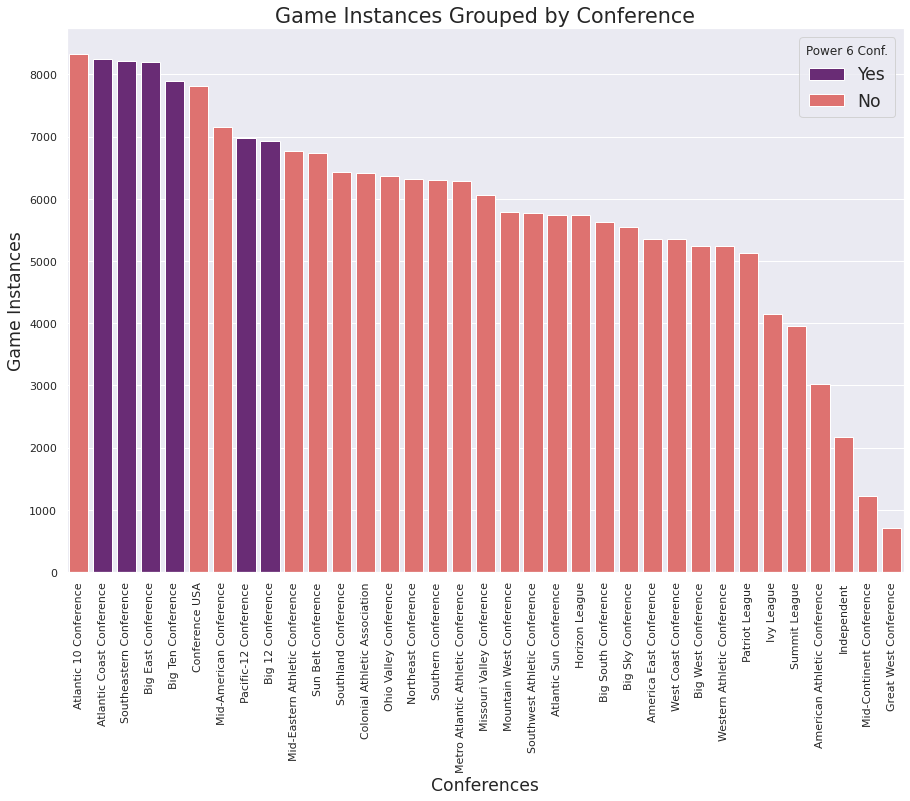

In [ ]:
# Make a count plot showing the game counts by conference with color variation to signal Power 6 conferences
#    (these are widely considered to be the best/most established in the sport).
plt.figure(figsize=(15, 10))
sns.set_theme()
g = sns.countplot(x='Conference', hue='Power6', palette='magma', data=combined_games_with_agg_df, order=combined_games_with_agg_df['Conference'].value_counts().index, dodge=False)
g.set_title("Game Instances Grouped by Conference", fontsize = 'xx-large')
g.set_xlabel("Conferences", fontsize = 'x-large')
g.set_ylabel("Game Instances", fontsize = 'x-large')
plt.legend(loc = 'upper right', fontsize = 'x-large', title = 'Power 6 Conf.')
plt.xticks(rotation=90)

plt.show()

## Bar Graph: Game Instances Per Average Number of Teams Grouped by Conference
Make a bar graph showing how many game instances we have in our combined_games_with_agg_df (all regular season, conference tournament, and March Madness tournament games with aggregate data) per average number of teams in each conference.


<br>**Motivation:**
<br>We want to inspect our dataset further to see how evenly the games are distributed among conferences when accounting for the average number of teams in each conference over the range of seasons we are analyzing. Hopefully, the conferences that contributed fewer game instances in the above graph do so because they consist of few teams or have existed for fewer years.

<br>**Conclusion:**
<br>As expected, the conferences contributing fewer game instances tend to have fewer teams or seasons. For instance, the American Athletic Conference has only been around for 9 seasons, while nearly all the larger contributing conferences produced 20 years of data in our studied snapshot. With slightly more seasons of data (13), the average number of Independent teams (no conference) per season is just 6.5 teams – half that of the largest Power 6 conferences. Finally, the Mid-Continent Conference and the Great West Conference, which have the fewest game instances, both lag behind the pack in terms of their average number of teams and seasons of data.

### Get the Data

In [ ]:
# Make conf_team_counts_df from avg_reg_season_games_df and combined_games_with_agg_df to hold the total game instances, number of teams,
#    number of seasons, and Power6 value, grouped by Conference.
merge_query = """
WITH

temp AS
(
  SELECT Season, Conference, COUNT(TeamID) AS Teams
  FROM avg_reg_season_games_df
  GROUP BY Season, Conference
),

temp2 AS
(
  SELECT Conference, AVG(Teams) AS AvgNumOfTeams, COUNT(Conference) AS Seasons
  FROM temp
  GROUP BY Conference
)

SELECT c.Conference, CAST(COUNT(TeamID) AS Int) AS 'Games', ROUND(t.AvgNumOfTeams, 1) AS 'Avg. Number of Teams', t.Seasons, Power6
FROM combined_games_with_agg_df c
JOIN temp2 t
ON c.Conference=t.Conference
GROUP BY c.Conference

"""

conf_team_counts_df = ps.sqldf(merge_query, locals())
conf_team_counts_df

,Conference,Games,Avg. Number of Teams,Seasons,Power6
0,America East Conference,5348,9.3,20,No
1,American Athletic Conference,3017,11.2,9,No
2,Atlantic 10 Conference,8323,13.8,20,No
3,Atlantic Coast Conference,8252,13.0,20,Yes
4,Atlantic Sun Conference,5734,10.1,20,No
5,Big 12 Conference,6928,10.9,20,Yes
6,Big East Conference,8205,12.9,20,Yes
7,Big Sky Conference,5550,10.0,20,No
8,Big South Conference,5626,10.2,20,No
9,Big Ten Conference,7893,12.3,20,Yes


In [ ]:
# Sort the DataFrame according to the prior graph's conference ordering.
conf_team_counts_df = conf_team_counts_df.sort_values('Games', ascending=False)

### Bar Graph

In [ ]:
y_series = (conf_team_counts_df['Games']/conf_team_counts_df['Avg. Number of Teams']).round(1)

fig = px.bar(conf_team_counts_df, x='Conference', y=y_series,
             hover_data={'Seasons':True, 'Avg. Number of Teams':':.1f'}, color='Power6', category_orders={"Power6": ["Yes", "No"]}, color_discrete_sequence=["purple", "Salmon"],
             height=800, title="Game Instances Per Average Number of Teams Grouped by Conference", labels={'y':'Game Instances Per Avg. Number of Teams in Conference'})
fig.show()
fig.write_html("/content/gdrive/MyDrive/March Madness/Graphs/BarGraph1.html")

## March Madness Tournament Team Instances Bar Graph by Conference
Make a bar graph showing how many team instances we have in our tourney_games_seeds_df of March Madness tournament games (all of these games are also included in combined_games_with_agg_df) grouped by conference.

<br>**Motivation:**
<br>Following up on the previous graph, let's see how many teams have made the March Madness tournament from each conference across our nearly two decades of tournament data. We anticipate that conferences with lower game instance counts in the prior graph will also contribute fewer teams to the end-of-year tournament.

<br>**Conclusion:**
<br>As expected, the Power 6 conferences produce many tournament teams, but the others are still important contributors collectively. Interestingly, despite having around 3,000 game instances, the American Athletic Conference has contributed a very respectable 21 teams to the big tournament. It's important to realize that this conference emerged after a major shakeup in the Big East in 2013 and has only existed for a small portion of the years observed – thus, its fewer game instances. Additionally, the only conferences with fewer game instances – Independent (teams with no conference), the Mid-Continent Conference, and the Great West Conference – either haven't sent any teams to the tournament or place in the bottom here with 5 teams (Great West Conference). The Great West Conference existed from 2010 to 2013 with only a small number of teams. In summary, the game instances figures appear sufficient when considering the March Madness participant distribution.

### Get the Data


#### Make a DataFrame containing the total team instances in the March Madness Tournament grouped by conference

We will also include additional average metrics and a count of the total number of schools contributing to these team instances (i.e., if a team like Duke sends its team to the tournament all 18 seasons, it would still only count as 1 school in this new metric). We will use this DataFrame again in later graphs.

<br>It's also worth noting that even though our dataset covers 20 years of NCAA Men's Basketball data, it only has 18 seasons' worth of March Madness tournament data. This is due to covid forcing the cancellation of the 2020 tournament, and this dataset not including the current 2022 tournament's data.

In [ ]:
# Make conference_tourney_counts_df from tourney_games_seeds_df to hold the total team instances, number of schools, and mean statistics
# for March Madness teams grouped by Conference.
merge_query = """
WITH

temp1_1 AS
(
  SELECT Season, TeamID, Conference
  FROM tourney_games_seeds_df t
  GROUP BY Season, TeamID, Conference
),

temp1_2 AS
(
  SELECT Conference, COUNT(TeamID) AS 'Tournament Team Instances'
  FROM temp1_1 t
  GROUP BY Conference
),

temp2_1 AS
(
  SELECT TeamID, Conference
  FROM tourney_games_seeds_df t
  GROUP BY TeamID, Conference
),

temp2_2 AS
(
  SELECT Conference, COUNT(TeamID) AS 'Schools'
  FROM temp2_1 t
  GROUP BY Conference
),

stats AS
(
  SELECT Conference, ROUND(AVG(g.'AvgWin%'), 1) AS 'Average Win%', g.Power6 AS 'Power6', ROUND(Avg(AvgRank), 1) as 'Average Rank',
         ROUND(AVG(AvgOppRank), 1) AS 'Average OppRank', ROUND(AVG(g.'AvgOppWin%'), 1) AS 'Average OppWin%'
  FROM tourney_games_seeds_df g
  GROUP BY Conference
),

stats_with_2 AS
(
  SELECT s.*, t.'Tournament Team Instances'
  FROM stats s
  JOIN temp1_2 t
  ON s.Conference=t.Conference
)

SELECT s.*, t.'Schools'
FROM stats_with_2 s
JOIN temp2_2 t
ON s.Conference=t.Conference
"""

conference_tourney_counts_df = ps.sqldf(merge_query, locals())
conference_tourney_counts_df

,Conference,Average Win%,Power6,Average Rank,Average OppRank,Average OppWin%,Tournament Team Instances,Schools
0,America East Conference,71.0,No,156.3,218.3,45.1,18,7
1,American Athletic Conference,79.5,No,30.4,121.9,54.4,21,10
2,Atlantic 10 Conference,76.1,No,45.5,126.8,54.0,54,14
3,Atlantic Coast Conference,75.7,Yes,20.5,90.8,57.6,107,16
4,Atlantic Sun Conference,72.2,No,131.7,214.7,44.6,18,9
5,Big 12 Conference,75.5,Yes,22.3,93.4,57.0,106,13
6,Big East Conference,75.7,Yes,24.7,95.1,57.1,117,18
7,Big Sky Conference,71.0,No,142.4,203.6,45.5,18,6
8,Big South Conference,65.2,No,171.2,212.7,45.4,18,6
9,Big Ten Conference,74.6,Yes,22.4,94.4,56.4,109,14


In [ ]:
# Reorder the DataFrame by descending Tournament Team Instances.
conference_tourney_counts_df = conference_tourney_counts_df.sort_values('Tournament Team Instances', ascending=False)

### Bar Graph

In [ ]:
# Make a bar plot showing the Tournament Team Instances by Conference with color variation to signal Power6 conferences
#    (these are widely considered to be the best/most established in the sport).
fig = px.bar(conference_tourney_counts_df, x='Conference', y='Tournament Team Instances',
             hover_data={'Schools':True}, color='Power6', category_orders={"Power6": ["Yes", "No"]}, color_discrete_sequence=["purple", "Salmon"],
             title="March Madness Tournament Team Instances by Conference", height=800)
fig.show()
fig.write_html("/content/gdrive/MyDrive/March Madness/Graphs/BarGraph2.html")

## Scatterplot: Average Ranking by Conference

<br>**Motivation:**
<br>We want to see how conferences compare in terms of their teams' average ranking and win percentage. This will show which conferences have performed the best over our dataset during the regular season and postseason. Again, we expect to see the Power 6 conferences perform best, but perhaps others will prove surprisingly strong. Additionally, this graph will give a good indication of how strongly rankings correlate with wins (this should be an inverse correlation because higher rankings equate to lower numbers) since conferences with higher average rankings (lower numbers) should also have higher average win percentages.

<br>**Conclusion:**
<br>As expected, the Power 6 conferences maintain higher rankings while outperforming the others in terms of win percentages. Among these, the Pac-12 appears to lag behind its elite peers. Of the non-Power 6 conferences, the American Athletic Conference and Mountain West Conference have performed best, but there is a clear gap between these and any of the Power 6. In terms of correlation, it certainly appears that the higher ranking conferences have higher win percentages, but perhaps this relationship could be better viewed when compared directly. First, however, let's view this graph again with only the Power 6 conferences to better see how they compare.

### Get the Data

In [ ]:
# Make a new temperary DataFrame from avg_reg_season_games_df grouping by Conferences using averages of Win%, Power6, and Rank.
merge_query = """
SELECT Conference, AVG(a.'AvgWin%') AS 'Average Win%', Power6, Avg(AvgRank) as 'Average Rank'
FROM avg_reg_season_games_df a
GROUP BY Conference
"""

temp_df = ps.sqldf(merge_query, locals())

### Scatterplot

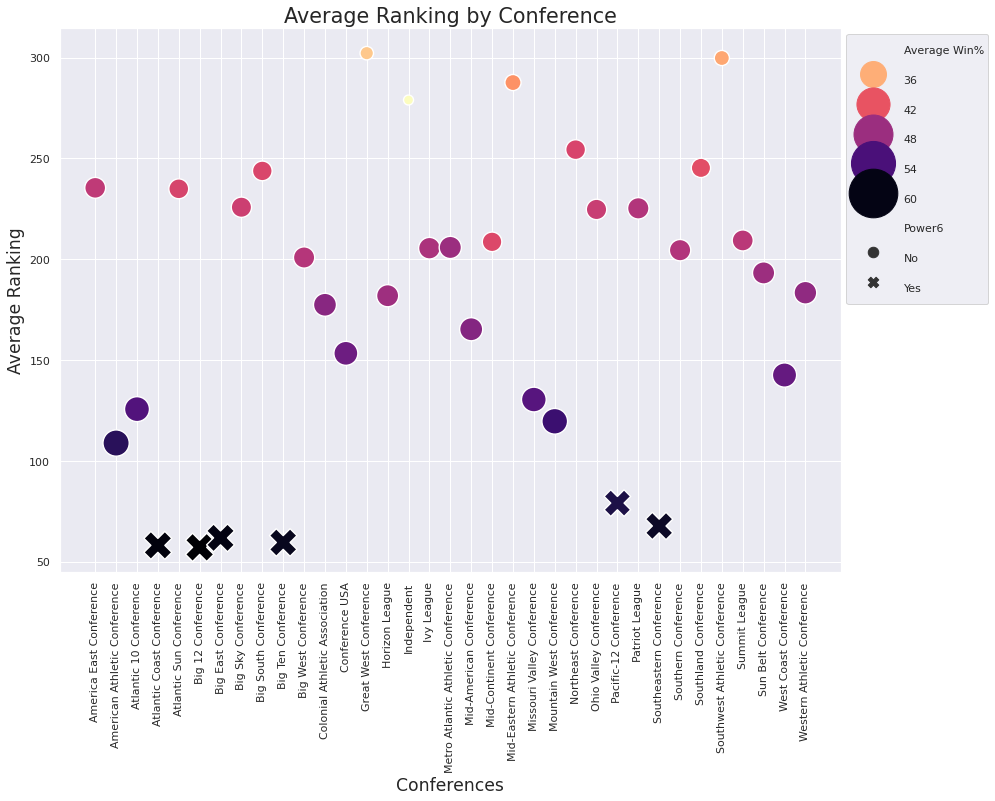

In [ ]:
# Make scatterplot of average ranking by conference with variations in color/size according to win% and markers according to Power6 value.
plt.figure(figsize=(14, 10))
sns.set_theme(style="darkgrid")
g = sns.scatterplot(x='Conference', y='Average Rank', palette='magma_r', data=temp_df, hue='Average Win%', size=('Average Win%'), sizes=(100, 800), style="Power6")
g.set_title("Average Ranking by Conference", fontsize = 'xx-large')
g.set_xlabel("Conferences", fontsize = 'x-large')
g.set_ylabel("Average Ranking", fontsize = 'x-large')
plt.legend(bbox_to_anchor= (1,1), handlelength=4, handleheight=3, markerscale=1.75)

plt.xticks(rotation=90)

plt.show()

## Scatterplot: Average Ranking by Power 6 Conference

<br>**Motivation:**
<br>After viewing the average rankings of the conferences in our dataset, we now want to focus on the Power 6 conferences to better see how the best stack up against each other.

<br>**Conclusion:**
<br>Clearly, the Southeastern Conference and Pacific-12 Conference lag behind their peers, with the latter having substantially lower average rankings and win percentages than the others. Its average win percentage is nearly four percentage points lower than the top-performing Big 12 Conference.

### Get the Data


In [ ]:
# Make a temperary DataFrame (temp2_df) from avg_reg_season_games_df of the Power6 conferences grouped by Conference using the averages of Win% and Rank.
merge_query = """
SELECT Conference, ROUND(AVG(a.'AvgWin%'), 1) AS 'Average Win%', Power6, Avg(AvgRank) as 'Average Rank'
FROM avg_reg_season_games_df a
WHERE Power6 == 'Yes'
GROUP BY Conference
"""

temp2_df = ps.sqldf(merge_query, locals())

### Scatterplot

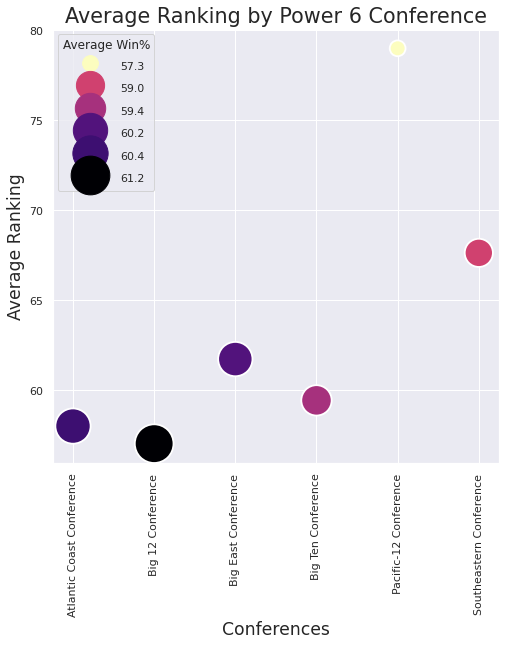

In [ ]:
# Make a scatterplot of average ranking by Power6 conference with variations in color/size according to Average Win%.
plt.figure(figsize=(8, 8))
sns.set_theme(style="darkgrid")
g = sns.scatterplot(x='Conference', y='Average Rank', palette='magma_r', data=temp2_df, hue='Average Win%', size=('Average Win%'), sizes=(250, 1500), legend='full')
g.set_title("Average Ranking by Power 6 Conference", fontsize = 'xx-large')
g.set_xlabel("Conferences", fontsize = 'x-large')
g.set_ylabel("Average Ranking", fontsize = 'x-large')
plt.legend(loc='upper left', handlelength=4, handleheight=2, markerscale=1, title='Average Win%')

plt.xticks(rotation=90)

plt.show()

## Scatterplot: Average Rank and Win Percentage of March Madness Tournament Teams Grouped by Conference

<br>**Motivation:**
<br>Building off the previous graphs, let's now look at the same data, but this time among March Madness Tournament teams. We will also view the data differently, with average conference win percentages plotted against their rankings. We should see a clear negative-sloped trend if the two are strongly correlated (negatively correlated on our graph since higher rankings equate to lower numbers). It will be interesting to see if the prior conference trends continue now that we are only looking at the top performers from each conference. Maybe the gap will lessen between the Power 6 conferences and everyone else. This new plot should give greater insights into how well teams from various conferences that will meet in the tournament compare.

<br>**Conclusion:**
<br>Power 6 conferences still place near the top in terms of average rankings, but the gap has shrunk, with a couple of non-Power 6 conferences overtaking the Pacific-12 Conference. On the whole, the negative correlation holds quite well.

The most significant outlier is the Mid-Continent Conference. With these teams coming from the less populated midwest (several are from the Dakotas) and the conference ultimately dissolving in 2007, perhaps the conference's lower win percentage is due to fewer out-of-conference games. Mathematically, a conference whose teams play zero out-of-conference games will have an average team win% of 50).

The most interesting element in this graph is seeing so many conferences sport higher win percentages than the Power 6. Of course, we'd expect teams making the tournament from smaller conferences to have had terrific seasons against lesser competition. As a result, any non-automatic bids from these conferences are held to higher standards than their Power 6 competitors. Nevertheless, the West Coast Conference's nearly 85 win percentage is staggering. That is until you realize that only four of its schools have sent teams to the tournament, with 18 of these 31 team instances coming from Gonzaga – a powerhouse in its own right, on par with the best of the Power 6.

### Scatterplot

In [ ]:
df = px.data.iris()
fig = px.scatter(conference_tourney_counts_df, x='Average Rank', y='Average Win%', color='Conference', size='Average OppRank', symbol = conference_tourney_counts_df['Power6'],
                 symbol_sequence= ['cross', 'circle'], hover_data=["Average OppWin%", "Schools", "Tournament Team Instances"],
                 title="Average Rank and Win Percentage of March Madness Tournament Teams Grouped By Conference", width=1000, height=850)

fig.show()
fig.write_html("/content/gdrive/MyDrive/March Madness/Graphs/Scatterplot.html")

## 3D Scatterplot: Average Rank and Win Percentage of March Madness Tournament Teams Grouped by Season and Conference

<br>**Motivation:**
<br>Let's try plotting the average ranking and win percentage by conference throughout multiple seasons to see how they compare over time. Perhaps certain trends will emerge showing rising or falling conferences.

<br>**Conclusion:**
<br>The most interesting finding from this graph is the different levels of variation among these conferences. For instance, from 2003 through 2010, the Pac-12 Conference maintained average tournament team rankings within the top 38. Yet, over the next ten tournaments, four seasons had average tournament team rankings above 40, with three above 50. In 2017, the Pac-12 had its second-highest average ranking at 22.7, but overall its average rankings appear to be trending down. Conversely, the Southeastern Conference has significantly tightened its spread, maintaining top 30 average rankings since 2010 following three straight years of falling rankings (37.3, 44.2, and 52.8). The Big 12 appears to be the top performer, and the ACC holds the best single-season performance (2008) with an average rank of 12.8 and win percentage of 84.7%.

### Get the Data

In [ ]:
merge_query = """
SELECT Season, Conference, ROUND(AVG(t.'AvgWin%'), 1) AS 'Average Win%', t.Power6 AS 'Power6', ROUND(Avg(t.AvgRank), 1) as 'Average Rank'
FROM tourney_games_seeds_df t
WHERE Power6 == 'Yes'
GROUP BY Season, Conference
ORDER BY Conference, Season
"""

temp3_df = ps.sqldf(merge_query, locals())
temp3_df

,Season,Conference,Average Win%,Power6,Average Rank
0,2003,Atlantic Coast Conference,74.3,Yes,20.5
1,2004,Atlantic Coast Conference,72.5,Yes,14.2
2,2005,Atlantic Coast Conference,77.8,Yes,15.3
3,2006,Atlantic Coast Conference,79.9,Yes,17.0
4,2007,Atlantic Coast Conference,71.6,Yes,27.8
...,...,...,...,...,...
103,2016,Southeastern Conference,73.6,Yes,23.0
104,2017,Southeastern Conference,73.9,Yes,26.3
105,2018,Southeastern Conference,67.0,Yes,28.8
106,2019,Southeastern Conference,75.6,Yes,22.8


### 3D Scatterplot

In [ ]:
df = px.data.iris()
fig = px.scatter_3d(temp3_df, x='Season', y='Average Rank', z='Average Win%', color='Conference',
                    title="Average Rank and Win Percentage of March Madness Tournament Teams Grouped By Season and Conference", width=1300, height=800)
fig.show()
fig.write_html("/content/gdrive/MyDrive/March Madness/Graphs/Scatterplot3D.html")

## Scatterplot: Average Metrics Among Final Four Teams by Season

<br>**Motivation:**
<br>A major focus of our project is to understand how well traditional seedings predict March Madness tournament results. One basic way of checking this is to see how reliably the best seeds make it to the Final Four. Let's look at the Final Four teams' average seed across seasons and check their average win percentage, ranking, and regular-season opponent ranking.

<br>**Conclusion:**
<br>Typically, the average Final Four seed is around 3, but interestingly there was only one year where all four #1 seeds made it out of their region (to the Final Four). This happened in 2008 with Kansas, North Carolina, UCLA, and Memphis. The former three are unsurprisingly college basketball blue bloods. At the same time, up-and-coming Memphis was led by future NBA MVP Derrick Rose and budding star coach John Calipari, who would eventually win a title with Kentucky. The 2008 Final Four teams also enjoyed the highest average Final Four team win percentage (93.2%) and rank (3.9). Interestingly, that year's teams faced one of the weaker groups of opponents, with a regular-season average ranking of 139.8. Despite playing easier competition before the tournament, these one seeds proved worthy of their lofty rankings.

Another intriguing year is 2011 when two cinderellas (Butler and VCU) made the Final Four. This season had the lowest average seed at 6.5, the lowest average team ranking at 39, and the lowest average win percentage at 72.2%. Even though seeds are pretty good predictors of Final Four teams, there is still room for improvement.

### Get the Data

In [ ]:
# Remove the letters before and after each and convert the results to integers, which we place in a new 'SeedInt' column.
tourney_games_seeds_df['SeedInt'] = tourney_games_seeds_df['Seed'].apply(lambda row: int(row[1:-1]) if row[-1:].isalpha() else int(row[1:]))

In [ ]:
# Collect the final four teams' average win percentage, seed, rank, and opponent rank.
merge_query = """
SELECT Season, ROUND(AVG(t.'AvgWin%'), 1) AS 'AvgWin%', ROUND(AVG(SeedInt), 1) as AvgSeed, ROUND(AVG(AvgRank), 1) as AvgRank, ROUND(AVG(AvgOppRank), 1) as AvgOppRank,
       AVG(Power6) AS AvgPower6
FROM tourney_games_seeds_df t
WHERE DayNum = 152
GROUP BY Season
"""

ff_avg_team_stats_df = ps.sqldf(merge_query, locals())

In [ ]:
# Get the final four teams.
merge_query = """
SELECT Season, TeamName
FROM tourney_games_seeds_df
WHERE DayNum = 152
"""

ff_teams_df = ps.sqldf(merge_query, locals())
ff_teams_df

,Season,TeamName
0,2003,Kansas
1,2003,Marquette
2,2003,Syracuse
3,2003,Texas
4,2004,Connecticut
...,...,...
67,2019,Virginia
68,2021,Baylor
69,2021,Gonzaga
70,2021,Houston


In [ ]:
# Get the final four team names for each season.

# Group by Season, and convert the TeamName to list.
# Now we have a list of lists with team names surrounded by single quotes.
ff_teams_temp = ff_teams_df.groupby('Season')['TeamName'].apply(list).tolist()

# Make an empty list to hold strings of the team names for each season (no qoutes around teams).
ff_teams = []
# For each sub-list in ff_teams_temp, convert the team elements to a single string and append it to ff_teams.
for i in ff_teams_temp:
  mystr=''
  for j in i:
    mystr = mystr + j + ', '
  ff_teams.append(mystr[:-2])
ff_teams

['Kansas, Marquette, Syracuse, Texas',
 'Connecticut, Duke, Georgia Tech, Oklahoma St',
 'Illinois, Louisville, Michigan St, North Carolina',
 'Florida, George Mason, LSU, UCLA',
 'Florida, Georgetown, Ohio St, UCLA',
 'Kansas, Memphis, North Carolina, UCLA',
 'Connecticut, Michigan St, North Carolina, Villanova',
 'Butler, Duke, Michigan St, West Virginia',
 'Butler, Connecticut, Kentucky, VCU',
 'Kansas, Kentucky, Louisville, Ohio St',
 'Louisville, Michigan, Syracuse, Wichita St',
 'Connecticut, Florida, Kentucky, Wisconsin',
 'Duke, Kentucky, Michigan St, Wisconsin',
 'North Carolina, Oklahoma, Syracuse, Villanova',
 'Gonzaga, North Carolina, Oregon, South Carolina',
 'Kansas, Loyola-Chicago, Michigan, Villanova',
 'Auburn, Michigan St, Texas Tech, Virginia',
 'Baylor, Gonzaga, Houston, UCLA']

In [ ]:
# Get the individuals lists from ff_avg_team_stats_df to use in our graph.
SeasonList = ff_avg_team_stats_df['Season'].tolist()
AvgSeedList = ff_avg_team_stats_df['AvgSeed'].tolist()
AvgRankList = ff_avg_team_stats_df['AvgRank'].tolist()
AvgWinPercList = ff_avg_team_stats_df['AvgWin%'].tolist()
AvgOppRankList = ff_avg_team_stats_df['AvgOppRank'].tolist()

### Scatterplot

In [ ]:
fig = go.Figure()

# Average seed plot.
fig.add_trace(go.Scatter(x=SeasonList, y=AvgSeedList,
                    mode='lines+markers',
                    name='Avg Seed',
                    customdata = ff_teams,
                    hovertemplate = '<b>Season</b>: %{x}<br>' +
                    '<b>Avg Seed</b>: %{y}<br>' +
                    '<i>Teams</i>: %{customdata}'))

# Average rank plot.
fig.add_trace(go.Scatter(x=SeasonList, y=AvgRankList,
                    mode='lines+markers',
                    name='Avg Rank',
                    customdata = ff_teams,
                    hovertemplate = '<b>Season</b>: %{x}<br>' +
                    '<b>Avg Rank</b>: %{y}<br>' +
                    '<i>Teams</i>: %{customdata}'))

# Average win percentage plot.
fig.add_trace(go.Scatter(x=SeasonList, y=AvgWinPercList,
                    mode='lines+markers',
                    name='Avg Win %',
                    customdata = ff_teams,
                    hovertemplate = '<b>Season</b>: %{x}<br>' +
                    '<b>Avg Win%</b>: %{y}<br>' +
                    '<i>Teams</i>: %{customdata}'))

# Average opponent rank plot.
fig.add_trace(go.Scatter(x=SeasonList, y=AvgOppRankList,
                    mode='lines+markers',
                    name='Avg Opponent Rank',
                    customdata = ff_teams,
                    hovertemplate = '<b>Season</b>: %{x}<br>' +
                    '<b>Avg Opponent Rank</b>: %{y}<br>' +
                    '<i>Teams</i>: %{customdata}'))

fig.update_layout(title = "Average Metrics Among Final Four Teams by Season")

fig.show()
fig.write_html("/content/gdrive/MyDrive/March Madness/Graphs/ScatterplotSeeds.html")

## Geo Scatterplot: Win Percentage of Teams by Season

<br>**Motivation:**
<br>Now, let's pivot to geographical data showing teams across a map of the United States over time. Their colors will correspond to their conferences, and their sizes will grow and shrink according to their average ranking that season (higher rankings equate to larger sizes). We will invert the average rankings, standardize the results, and use these figures as our size variable. Finally, Power 6 conference teams will appear with a cross marker. For fun, let's see which regions of the country have had the best teams and where most teams are located.

<br>**Conclusion:**
<br>By far, the majority of college basketball teams reside in the eastern half of the country, with the most densely packed region being the northeast. Moving deeper into the midwest, schools become very sparse. Top performers hail from many different areas over the years. Some pop up along the east coast, in the south, near The Great Lakes, and out west in California and Washington.

### Get the Data

In [ ]:
# Fill in any NaN AvgRank values with 1 more than the largest AvgRank number for teams without an average ranking.
# This will become our marker sizing feature.
avg_reg_season_games_df['AvgRankFilledNa'] = avg_reg_season_games_df['AvgRank'].fillna(round(avg_reg_season_games_df['AvgRank'].max()+1))

# Since higher ranking teams have lower rank numbers, let's invert these values.
avg_reg_season_games_df['GraphSize'] = avg_reg_season_games_df['AvgRankFilledNa'].apply(lambda x: 1/x)

# Standardize the new AvgRank (GraphSize) values.
# However, we cannot have negative marker sizes, so we will shift all values upward, such that the lowest is 1.
mean = avg_reg_season_games_df['GraphSize'].mean()
std = avg_reg_season_games_df['GraphSize'].std()
avg_reg_season_games_df['GraphSize'] = avg_reg_season_games_df['GraphSize'].apply(lambda x: (x - mean)/(std))
min = avg_reg_season_games_df['GraphSize'].min()
avg_reg_season_games_df['GraphSize'] = avg_reg_season_games_df['GraphSize'].apply(lambda x: x - min + 1)

# Make a copy of avg_reg_season_games_df with rounded AvgWin%, AvgOppWin%, and AvgOppRank values.
rounded_avg_reg_season_games_df = avg_reg_season_games_df.copy()
rounded_avg_reg_season_games_df['AvgWin%'] = rounded_avg_reg_season_games_df['AvgWin%'].round(1)
rounded_avg_reg_season_games_df['AvgOppWin%'] = rounded_avg_reg_season_games_df['AvgOppWin%'].round(1)
rounded_avg_reg_season_games_df['AvgRank'] = rounded_avg_reg_season_games_df['AvgRank'].round(1)
rounded_avg_reg_season_games_df['AvgOppRank'] = rounded_avg_reg_season_games_df['AvgOppRank'].round(1)

# fill any NaN values in AvgRank and AvgOppRank with 'None'.
rounded_avg_reg_season_games_df['AvgRank'] = rounded_avg_reg_season_games_df['AvgRank'].fillna('None')
rounded_avg_reg_season_games_df['AvgOppRank'] = rounded_avg_reg_season_games_df['AvgOppRank'].fillna('None')

In [ ]:
# Sort values by Season and Conference.
rounded_avg_reg_season_games_df = rounded_avg_reg_season_games_df.sort_values(by=['Season', 'Conference'])
rounded_avg_reg_season_games_df

,Season,TeamID,AvgRank,AvgOppRank,AvgWin%,AvgOppWin%,PPG,AdjPPG,AvgScoreDiff,FGM/Game,...,Seed,CoachName,SeasonDaysCoached,TotalDaysCoached,CoachesInYear,Location,Latitude,Longitude,AvgRankFilledNa,GraphSize
59,2003,1306,311.5,217.8,17.9,47.5,65.500000,65.500000,-11.928571,21.750000,...,None,Phil Rowe,154,154,1,"Durham, NH",43.134564,-70.927048,311.452184,1.013101
74,2003,1318,237.7,212.9,48.3,44.8,72.172414,71.831418,-0.275862,25.827586,...,None,Ron Everhart,154,154,1,"Boston, MA",42.360253,-71.058291,237.749076,1.046539
89,2003,1436,183.5,211.1,65.5,43.7,67.793103,67.255172,4.655172,24.827586,...,Z16,Tom Brennan,154,154,1,"Burlington, VT",44.476160,-73.212906,183.474485,1.088338
131,2003,1392,247.1,214.6,42.3,43.9,64.269231,63.241026,-3.192308,22.423077,...,None,Nick Macarchuk,154,154,1,"Stony Brook, NY",40.908701,-73.139604,247.148546,1.041165
218,2003,1107,287.3,207.9,25.0,48.5,65.928571,64.161760,-9.785714,24.035714,...,None,Will Brown,154,154,1,"Albany, NY",42.651167,-73.754968,287.304821,1.022167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6703,2022,1410,275.5,197.0,23.8,53.6,72.714286,72.714286,-7.428571,25.142857,...,None,Matt Figger,98,98,1,"Edinburg, TX",26.301398,-98.162450,275.547225,1.027156
6730,2022,1152,330.6,205.3,26.1,45.3,62.826087,62.826087,-11.565217,22.130435,...,None,Gerald Gillion,98,98,1,"Chicago, IL",41.875562,-87.624421,330.574708,1.006861
6775,2022,1101,126.3,206.3,63.2,45.1,73.526316,72.216374,3.368421,25.263158,...,None,Brette Tanner,98,98,1,"Abilene, TX",32.446450,-99.747591,126.267844,1.171293
6815,2022,1249,326.4,195.8,0.0,45.5,62.850000,62.850000,-11.850000,23.350000,...,None,Alvin Brooks,98,98,1,"Beaumont, TX",30.086046,-94.101846,326.371011,1.008170


### Geo Scatterplot

In [ ]:
df = px.data.gapminder()
fig = px.scatter_geo(rounded_avg_reg_season_games_df, lat=rounded_avg_reg_season_games_df['Latitude'], lon=rounded_avg_reg_season_games_df['Longitude'], color='Conference',
                     hover_name='TeamName', size='GraphSize', symbol = rounded_avg_reg_season_games_df['Power6'], symbol_sequence= ['circle', 'cross'],
                     hover_data={'Longitude':False, 'Latitude':False, 'Location':True, 'Conference':True, 'GraphSize':False,
                                 'Season':False, 'AvgRank':True, 'AvgWin%':True, 'AvgOppRank':True, 'AvgOppWin%':True},
                     animation_frame='Season', scope='usa', title="Average Ranking of Each Team Over the Course of Each Season",
                     width=1400, height=700)
fig.show()
fig.write_html("/content/gdrive/MyDrive/March Madness/Graphs/ScatterplotGeo.html")

# Challenges Faced



*   Wrangling:

  There were many challenges during the wrangling process. Firstly, the large number of tables and joins and the ever-growing number of columns, with aggregate values for TeamID and OppTeamID, made the process very arduous. Furthermore, a significant hurdle was figuring out how to calculate the DayRank and OppDayRank. Team rankings update sporadically every few days, and it wasn't easy figuring out how to merge these with combined_games_df, which have different DayNum values corresponding to games. Ultimately, we used team/season-specific ffill() and bfill() methods calls to forward and then backward pad values following an outer merge. By forward filling, we kept a team's ranking constant until a new value came in. By backward filling, we populated early-season game data, during which teams hadn't yet received rankings. Afterward, we dropped the extra ranking instances that didn't correspond to games in combined_games_df.

  Additionally, pulling the city coordinates wasn't as straightforward as initially imagined. Nominatim would often timeout over our large cities dataset. The first approach was to divide the data into smaller pieces, but this didn't work reliably. Instead, we ended up incorporating a RateLimiter with a minimum delay. This cleaned up the process at the cost of a lengthy runtime.









# Next Steps

*   Wrangling:

  It would be fun to try and develop a more sophisticated method to calculate the DayRank and fill any of its 'NaN' values. For example, perhaps we could use a weighted average of rankings posted between a team's games to aggregate all of their newly published rankings in that span, weighting these by some measure of their source's historical ranking accuracy, and then supplying the result to the team's DayRank in their next game instance in combined_games_df.